# Bosonic Bath

## Total Hamiltonian: $H = H_S + H_B + H_{SB}$

We define the total Hamiltonian of the system as the sum of three components:

\begin{equation}
H = H_S + H_B + H_{SB}
\end{equation}

---

### 1. System Hamiltonian ($H_S$)

This term describes the internal dynamics of the quantum system of interest (e.g., qubits). For a two-qubit example:

\begin{equation}
H_S = X_1 + X_2
\end{equation}

Here, $X_1$ and $X_2$ are Pauli-$X$ operators acting on qubit 1 and qubit 2, respectively. This drives coherent oscillations (bit flips) between the $\lvert 0 \rangle$ and $\lvert 1 \rangle$ states.

---

### 2. Bath Hamiltonian ($H_B$)

This term models the environment (or reservoir) as a collection of bosonic modes. If each qubit is coupled to its own local bath with $M$ modes, then:

\begin{equation}
H_B = \sum_{i=1}^{N} \sum_{k=1}^{M} \omega_{ik} a_{ik}^\dagger a_{ik}
\end{equation}

Each $a_{ik}^\dagger$, $a_{ik}$ is a creation/annihilation operator for the $k$-th mode of the bath attached to qubit $i$, with frequency $\omega$. This represents the energy of each harmonic oscillator mode in the environment.

---

### 3. System-Bath Interaction ($H_{SB}$)

This term introduces coupling between each qubit and its corresponding bath modes:

\begin{equation}
H_{SB} = \sum_{i=1}^{N} \sum_{k=1}^{M} \frac{g}{\sqrt{M}} Z_i \left( a_{ik} + a_{ik}^\dagger \right)
\end{equation}

Here:
- $Z_i$ is the Pauli-$Z$ operator acting on qubit $i$.
- $a_{ik}$ corresponds to the $k$-th mode of the bath coupled to qubit $i$.
- $g$ is the system-bath coupling strength.
- $N$ is the number of qubits.
- $M$ is the number of modes per bath.

This interaction induces **pure dephasing**, meaning the bath affects the relative phase of the qubit states but not their populations in the computational basis.

---

Putting all these pieces together allows us to simulate the open quantum system dynamics under both unitary and dissipative evolution.

---

The observable that was used is:

\begin{equation}
O = \sum_i \epsilon_i Z_i
\end{equation}

In [2]:
#Ignore this, this is just some parameters for the plot

# Define the layout of the user interface for the plot
import matplotlib.pyplot as plt
layout = 'vertical'  # or 'horizontal'
plt.rcParams.update({
    'font.size': 14,           # General font size
    'axes.titlesize': 16,      # Size of axes titles
    'axes.labelsize': 16,      # Size of axes labels
    'legend.fontsize': 14,     # Size of legend text
    'xtick.labelsize': 16,     # Size of x-tick labels
    'ytick.labelsize': 16      # Size of y-tick labels
})
y= 0.98 # y-coordinate for the legend position


## 1 QUBIT

### X_1

\begin{equation}
H_S = \alpha_1X_1
\end{equation}

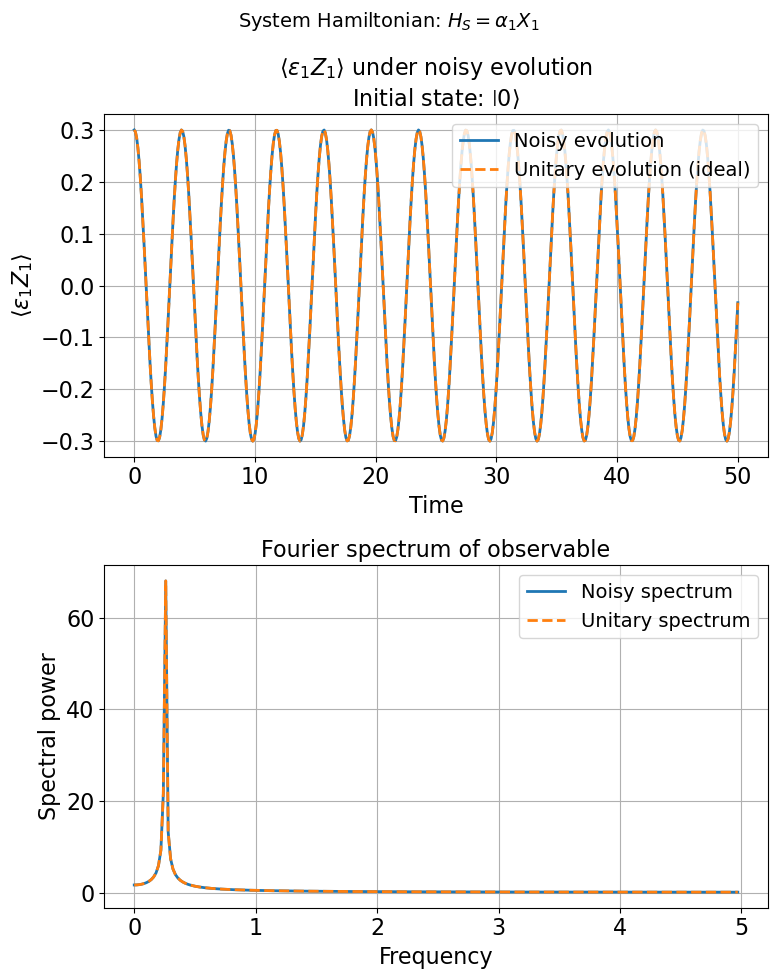

The dominant frequency from the Fourier transform is: 0.2595 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.2595 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
np.random.seed(42)

# Parameters

g = 0.01
num_modes_per_bath = 5
num_qubits = 1  # Number of qubits
N = 2  # Fock space truncation
kappa = 0.0001
tlist = np.linspace(0, 50, 500)
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\1QUBITS" #To save the images

# Function to build local operators embedded in full Hilbert space
def build_op(op_qubit, pos):
    ops = [qeye(2) for _ in range(num_qubits)] + [qeye(N) for _ in range(num_qubits * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)

# Pauli operators in the full Hilbert space
X1_full = build_op(sigmax(), 0)

# Bath creation/annihilation operators
# Bath creation/annihilation operators
a_ops = []
for i in range(num_qubits * num_modes_per_bath):
    ops = [qeye(2) for _ in range(num_qubits)] + [destroy(N) if j == i else qeye(N) for j in range(num_qubits * num_modes_per_bath)]
    a_ops.append(tensor(ops))

# Random coefficients for ε₁ and ε₂
epsilon1=0.3
alpha1 = 0.8
# System Hamiltonian: H_S = X₁ + X₂
Hs = alpha1* X1_full 

# Bath Hamiltonian
# Assign different omega_i to each bath mode
omega_list = np.random.uniform(0.5, 2.0, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(num_qubits):
    Z = build_op(sigmaz(), qubit)
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * Z * (a + a.dag())

# Total Hamiltonian
H_total = Hs + Hb  
# Initial state of the full system: (|00⟩ + |11⟩)/√2 ⊗ |0⟩_bath
zero0 = tensor(basis(2, 0), *[basis(N, 0) for _ in range(num_qubits * num_modes_per_bath)])

# Evolution with noise (open system)
result_noisy = mesolve(H_total, zero0, tlist, [])

# Evolution without noise (unitary)
result_unitary = sesolve(Hs, zero0, tlist)

# Reduced observable: ε₁ Z₁
Z1 = sigmaz()
observable_op = epsilon1 * Z1

# Compute expectation values with normalization of reduced density matrices
observable_noisy = []
observable_unitary = []

for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):
    # Partial trace to single qubits
        rho_noisy_0 = noisy_state.ptrace(0)
        # Normalize reduced single-qubit density matrices
        rho_noisy_0 = rho_noisy_0 / rho_noisy_0.tr()
        val_noisy = expect(observable_op, rho_noisy_0)
        observable_noisy.append(val_noisy)
        #For the ideal case
        rho_unitary = unitary_state.ptrace(0)
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_unitary.append(val_unitary)        

# Fourier Transform of energy from noisy expectation values
energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Fourier Transform of energy from unitary expectation values
energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
freqs_noisy = freqs_unitary = freqs
spectrum_noisy = energy_noisy_fft
spectrum_unitary = energy_unitary_fft

# Plot observable and its Fourier spectrum side by side
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(r'System Hamiltonian: $H_S = \alpha_1 X_1$', fontsize=14, y=y)

# Left: Observable ⟨ε₁ Z₁ + ε₂ Z₂⟩
axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution (ideal)', lw=2, color='tab:orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 \rangle$')
axs[0].set_title(
    r'$\langle \epsilon_1 Z_1 \rangle$ under noisy evolution' '\n'
    r'Initial state: $ \left |0\right \rangle $'

)
axs[0].legend( loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs_noisy >= 0

freqs_noisy= freqs_noisy[pos_mask]
freqs_unitary = freqs_unitary[pos_mask]
spectrum_noisy = spectrum_noisy[pos_mask]
spectrum_unitary = spectrum_unitary[pos_mask]
axs[1].plot(freqs_noisy, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
axs[1].plot(freqs_unitary, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')

axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].legend()
axs[1].grid(True)

name=  "ket_0_X1"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path,name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()


# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(spectrum_noisy)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs_noisy[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(spectrum_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary = freqs_unitary[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

Now I am testing a different $H_{sb}$, with a differente observable
\begin{equation}
H_{SB} = \sum_{i=1}^{N} \sum_{k=1}^{M} \frac{g}{\sqrt{M}} X_i \left( a_{ik} + a_{ik}^\dagger \right)
\end{equation}

\begin{equation}
O = \sum_i \epsilon_i X_i
\end{equation}

### Z_1

\begin{equation}
H_s = Z_1
\end{equation}

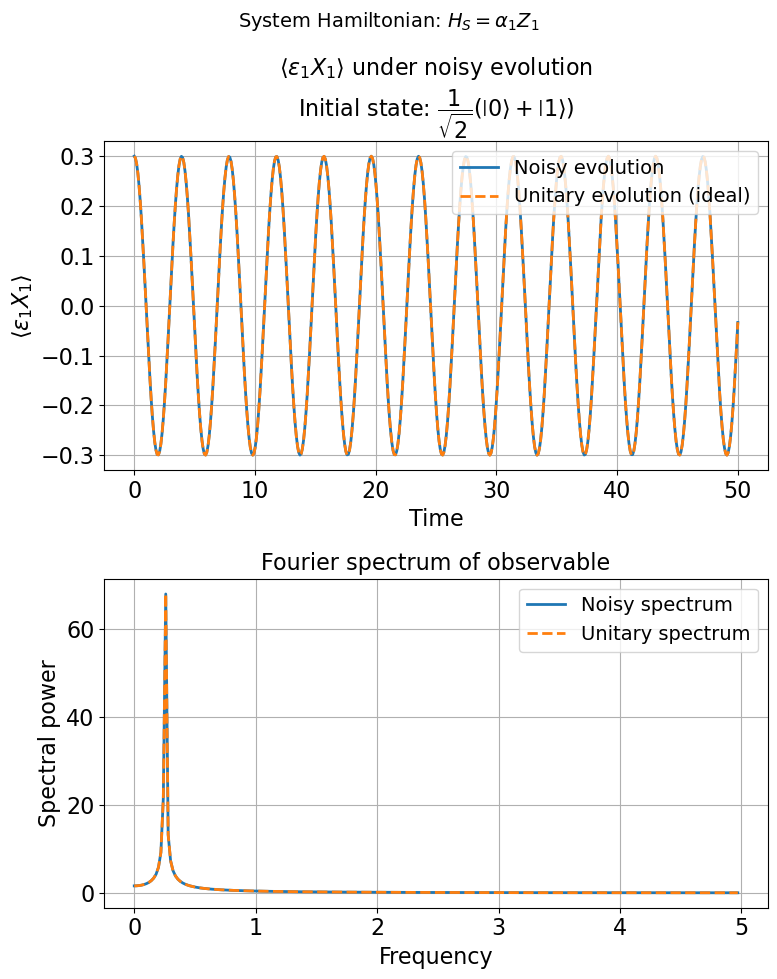

The dominant frequency from the Fourier transform is: 0.2595 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.2595 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [24]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
np.random.seed(42)

# Parameters

g = 0.01
num_modes_per_bath = 2
num_qubits = 1  # Number of qubits
N = 2  # Fock space truncation
kappa = 0.0001
tlist = np.linspace(0, 50, 500)
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\1QUBITS" #To save the images

# Function to build local operators embedded in full Hilbert space
def build_op(op_qubit, pos):
    ops = [qeye(2) for _ in range(num_qubits)] + [qeye(N) for _ in range(num_qubits * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)

# Pauli operators in the full Hilbert space
Z1_full = build_op(sigmaz(), 0)

# Bath creation/annihilation operators
# Bath creation/annihilation operators
a_ops = []
for i in range(num_qubits * num_modes_per_bath):
    ops = [qeye(2) for _ in range(num_qubits)] + [destroy(N) if j == i else qeye(N) for j in range(num_qubits * num_modes_per_bath)]
    a_ops.append(tensor(ops))

# Random coefficients for ε₁ and ε₂
epsilon1=0.3
alpha1 = 0.8
# System Hamiltonian: H_S = Z₁ 
Hs = alpha1* Z1_full 

# Bath Hamiltonian
# Assign different omega_i to each bath mode
omega_list = np.random.uniform(0.5, 2.0, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(num_qubits):
    X = build_op(sigmax(), qubit)
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * X * (a + a.dag())

# Total Hamiltonian
H_total = Hs + Hb + Hsb

# Initial state of the full system:
zero = tensor(basis(2, 0), *[basis(N, 0) for _ in range(num_qubits * num_modes_per_bath)])
one  = tensor(basis(2, 1), *[basis(N, 0) for _ in range(num_qubits * num_modes_per_bath)])
psi = (zero+one).unit()

# Evolution with noise (open system)
result_noisy = mesolve(H_total, psi, tlist, [])

# Evolution without noise (unitary)
result_unitary = sesolve(Hs, psi, tlist)


# Reduced observable: ε₁ Z₁
X1 = sigmax()
observable_op = epsilon1 * X1

# Compute expectation values with normalization of reduced density matrices
observable_noisy = []
observable_unitary = []

for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):
    # Partial trace to single qubits
        rho_noisy_0 = noisy_state.ptrace(0)
        # Normalize reduced single-qubit density matrices
        rho_noisy_0 = rho_noisy_0 / rho_noisy_0.tr()
        val_noisy = expect(observable_op, rho_noisy_0)
        observable_noisy.append(val_noisy)
        #For the ideal case
        rho_unitary = unitary_state.ptrace(0)
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_unitary.append(val_unitary)        

# Fourier Transform of energy from noisy expectation values
energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Fourier Transform of energy from unitary expectation values
energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
freqs_noisy = freqs_unitary = freqs
spectrum_noisy = energy_noisy_fft
spectrum_unitary = energy_unitary_fft

# Plot observable and its Fourier spectrum side by side
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(r'System Hamiltonian: $H_S = \alpha_1 Z_1$', fontsize=14, y=y)

# Left: Observable ⟨ε₁ Z₁ + ε₂ Z₂⟩
axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution (ideal)', lw=2, color='tab:orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 X_1 \rangle$')
axs[0].set_title(
    r'$\langle \epsilon_1 X_1 \rangle$ under noisy evolution' '\n'
    r'Initial state: $ \dfrac{1}{\sqrt{2}} (\left |0\right \rangle +\left |1\right \rangle)$'

)
axs[0].legend( loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs_noisy >= 0

freqs_noisy= freqs_noisy[pos_mask]
freqs_unitary = freqs_unitary[pos_mask]
spectrum_noisy = spectrum_noisy[pos_mask]
spectrum_unitary = spectrum_unitary[pos_mask]
axs[1].plot(freqs_noisy, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
axs[1].plot(freqs_unitary, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')

axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].legend()
axs[1].grid(True)

name=  "ket_0_Z_1"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path,name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()



# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(spectrum_noisy)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs_noisy[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(spectrum_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary = freqs_unitary[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

## 2 QUBITS

### X_1 + X_2

\begin{equation}
H_S = \alpha_1X_1 + \alpha_2X_2
\end{equation}


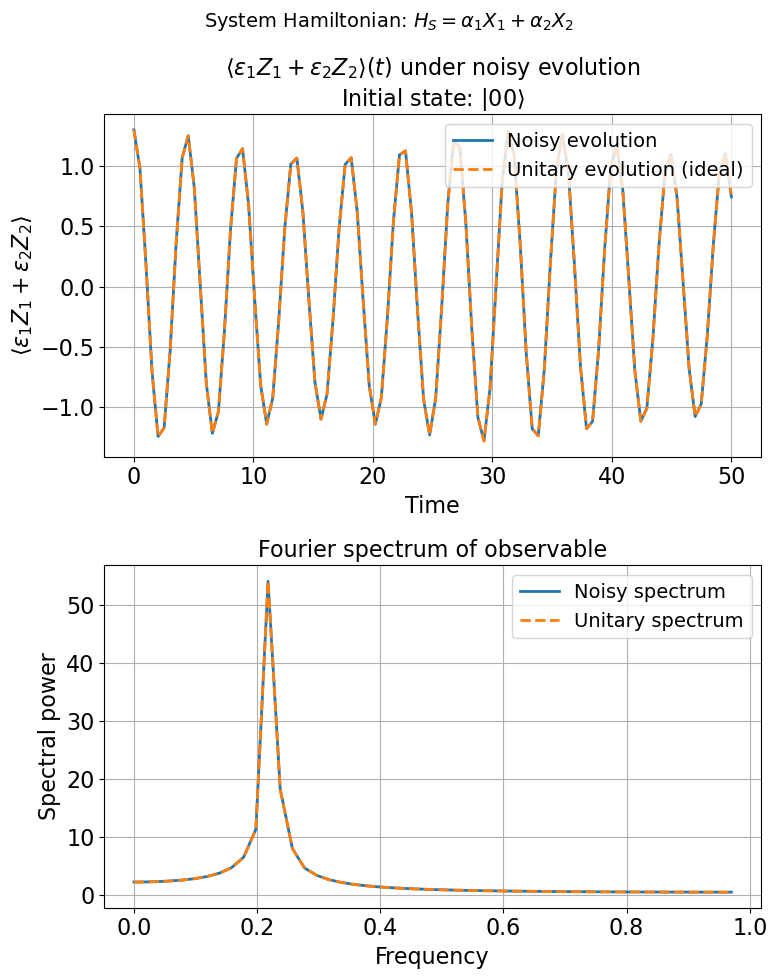

The dominant frequency from the Fourier transform is: 0.2178 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.2178 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [25]:


import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
from scipy.signal import find_peaks



# Parameters

g = 0.01
num_modes_per_bath = 2
N = 3  # Fock space truncation
kappa = 0.1
tlist = np.linspace(0,50, 100)
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\2QUBITS" #To save the images
num_qubits = 2  # Number of qubits

# Function to build local operators embedded in full Hilbert space
def build_op(op_qubit, pos):
    ops = [qeye(2) for _ in range(num_qubits)] + [qeye(N) for _ in range(num_qubits * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)

# Pauli operators in the full Hilbert space
X1_full = build_op(sigmax(), 0)
X2_full = build_op(sigmax(), 1)
Z1_full = build_op(sigmaz(), 0)
Z2_full = build_op(sigmaz(), 1)

# Bath creation/annihilation operators
a_ops = []
for i in range(num_qubits * num_modes_per_bath):
    ops = [qeye(2) for _ in range(num_qubits)] + [destroy(N) if j == i else qeye(N) for j in range(num_qubits * num_modes_per_bath)]
    a_ops.append(tensor(ops))

# Random coefficients for ε₁ and ε₂
epsilon1=0.1
epsilon2=1.2
alpha1 = 0.8
alpha2 = 0.7
# System Hamiltonian: H_S = X₁ + X₂
Hs = alpha1* X1_full + alpha2*X2_full

# Bath Hamiltonian
# Assign different omega_i to each bath mode
omega_list = np.random.uniform(0.1, 2.0, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(2):
    Z = build_op(sigmaz(), qubit)
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * Z * (a + a.dag())

# Total Hamiltonian
H_total = Hs + Hb + Hsb

# Initial state of the full system: (|00⟩ + |11⟩)/√2 ⊗ |0⟩_bath
zero0 = tensor(basis(2, 0), basis(2, 0), *[basis(N, 0) for _ in range(2 * num_modes_per_bath)])


psi= zero0

    
# Evolution with noise (open system)
result_noisy = mesolve(H_total, psi, tlist, [])

# Evolution without noise (unitary)
result_unitary = sesolve(Hs, psi, tlist)

# Reduced observable: ε₁ Z₁ + ε₂ Z₂ on the 2-qubit system
Z1 = tensor(sigmaz(), qeye(2))
Z2 = tensor(qeye(2), sigmaz())
observable_op = epsilon1 * Z1 + epsilon2 * Z2

# Compute expectation values with normalization of reduced density matrices
observable_noisy = []
observable_unitary = []

for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):
    # Partial trace to single qubits
    rho_noisy = noisy_state.ptrace([0, 1])
    rho_noisy = rho_noisy / rho_noisy.tr()  # Normalize the reduced density matrix
    # Compute expectation value of the observable
    val_noisy = expect(observable_op, rho_noisy)
    observable_noisy.append(val_noisy)

    #For the ideal case
    rho_unitary = unitary_state.ptrace([0, 1])
    rho_unitary = rho_unitary / rho_unitary.tr()
    val_unitary = expect(observable_op, rho_unitary)
    observable_unitary.append(val_unitary)
    

# Fourier Transform of energy from noisy expectation values
energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Fourier Transform of energy from unitary expectation values
energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
freqs_noisy = freqs_unitary = freqs
spectrum_noisy = energy_noisy_fft
spectrum_unitary = energy_unitary_fft

# Plot observable and its Fourier spectrum side by side
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(r'System Hamiltonian: $H_S = \alpha_1 X_1 +\alpha_2 X_2$', fontsize=14, y=y)

# Left: Observable ⟨ε₁ Z₁ + ε₂ Z₂⟩
axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution (ideal)', lw=2, color='tab:orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 \rangle$')
axs[0].set_title(
    r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 \rangle(t)$ under noisy evolution' '\n'
    r'Initial state: $|00\rangle$'

)
axs[0].legend( loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs_noisy >= 0

freqs_noisy= freqs_noisy[pos_mask]
freqs_unitary = freqs_unitary[pos_mask]
spectrum_noisy = spectrum_noisy[pos_mask]
spectrum_unitary = spectrum_unitary[pos_mask]
axs[1].plot(freqs_noisy, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
axs[1].plot(freqs_unitary, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')
axs[1].legend()
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].legend(loc='upper right')
axs[1].grid(True)
axs[1].grid(True)
name = "X1_X2"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path,name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()


# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(spectrum_noisy)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs_noisy[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(spectrum_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary = freqs_unitary[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

### X_1X_2+Y_1Y_2

\begin{equation}
H_S = \alpha_1 X_1X_2+ \alpha_2 Y_1Y_2
\end{equation}

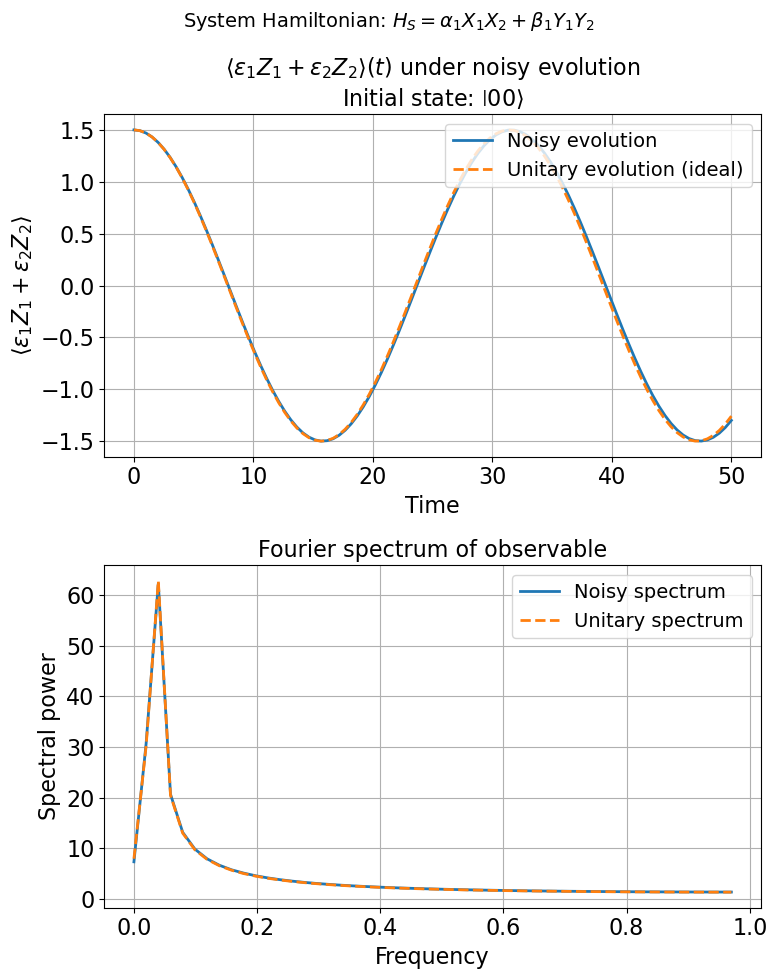

The dominant frequency from the Fourier transform is: 0.0396 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.0396 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [26]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
np.random.seed(42)

# Parameters

g = 0.05
num_modes_per_bath = 2
N = 2  # Fock space truncation
kappa = 0.1
tlist = np.linspace(0, 50, 100)
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\2QUBITS" #To save the images
num_qubits = 2  # Number of qubits

# Function to build local operators embedded in full Hilbert space
def build_op(op_qubit, pos):
    ops = [qeye(2) for _ in range(num_qubits)] + [qeye(N) for _ in range(num_qubits * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)

# Pauli operators in the full Hilbert space
X1_full = build_op(sigmax(), 0)
X2_full = build_op(sigmax(), 1)
Z1_full = build_op(sigmaz(), 0)
Z2_full = build_op(sigmaz(), 1)
Y1_full = build_op(sigmay(), 0)
Y2_full = build_op(sigmay(), 1)

# Bath creation/annihilation operators
a_ops = []
for i in range(num_qubits * num_modes_per_bath):
    ops = [qeye(2) for _ in range(num_qubits)] + [destroy(N) if j == i else qeye(N) for j in range(num_qubits * num_modes_per_bath)]
    a_ops.append(tensor(ops))

# Random coefficients for ε₁ and ε₂
epsilon1=0.3
epsilon2=1.2
alpha1 = 0.8
beta1 = 0.7
# System Hamiltonian: H_S = α₁ X₁ X₂ + α₂ Y₁ Y₂

Hs = alpha1* X1_full * X2_full  + beta1* Y1_full * Y2_full

# Bath Hamiltonian
# Assign different omega_i to each bath mode
omega_list = np.random.uniform(0.5, 2.0, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(2):
    Z = build_op(sigmaz(), qubit)
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * Z * (a + a.dag())

# Total Hamiltonian
H_total = Hs + Hb + Hsb

# Initial state of the full system:  |00⟩ ⊗ |0⟩_bath
zero0 = tensor(basis(2, 0), basis(2, 0), *[basis(N, 0) for _ in range(2 * num_modes_per_bath)])


psi= zero0

    
# Evolution with noise (open system)
result_noisy = mesolve(H_total, psi, tlist, [])

# Evolution without noise (unitary)
result_unitary = sesolve(Hs, psi, tlist)

# Reduced observable: ε₁ Z₁ + ε₂ Z₂ on the 2-qubit system
Z1 = tensor(sigmaz(), qeye(2))
Z2 = tensor(qeye(2), sigmaz())
observable_op = epsilon1 * Z1 + epsilon2 * Z2

# Compute expectation values with normalization of reduced density matrices
observable_noisy = []
observable_unitary = []

for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):
    rho_noisy = noisy_state.ptrace([0, 1])
    rho_noisy = rho_noisy / rho_noisy.tr()  # Normalize the reduced density matrix
    # Compute expectation value of the observable
    val_noisy = expect(observable_op, rho_noisy)
    # Append the value to the list

    observable_noisy.append(val_noisy)

    #For the ideal case
    rho_unitary = unitary_state.ptrace([0, 1])
    rho_unitary = rho_unitary / rho_unitary.tr()
    val_unitary = expect(observable_op, rho_unitary)
    observable_unitary.append(val_unitary)
    

# Fourier Transform of energy from noisy expectation values
energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Fourier Transform of energy from unitary expectation values
energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
freqs_noisy = freqs_unitary = freqs
spectrum_noisy = energy_noisy_fft
spectrum_unitary = energy_unitary_fft

# Plot observable and its Fourier spectrum side by side
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(r'System Hamiltonian: $H_S = \alpha_1 X_1X_2 +\beta_1 Y_1Y_2$', fontsize=14, y=y)

# Left: Observable ⟨ε₁ Z₁ + ε₂ Z₂⟩
axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution (ideal)', lw=2, color='tab:orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 \rangle$')
axs[0].set_title(
    r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 \rangle(t)$ under noisy evolution' '\n'
    r'Initial state: $ \left |00\right \rangle $'

)
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs_noisy >= 0

freqs_noisy= freqs_noisy[pos_mask]
freqs_unitary = freqs_unitary[pos_mask]
spectrum_noisy = spectrum_noisy[pos_mask]
spectrum_unitary = spectrum_unitary[pos_mask]
axs[1].plot(freqs_noisy, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
axs[1].plot(freqs_unitary, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].legend(loc='upper right')
axs[1].grid(True)
name = "X1X2_Y1Y2"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path,name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(spectrum_noisy)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs_noisy[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(spectrum_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary = freqs_unitary[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

Now I am testing a different $H_{sb}$, with a differente observable
\begin{equation}
H_{SB} = \sum_{i=1}^{N} \sum_{k=1}^{M} \frac{g}{\sqrt{M}} X_i \left( a_{ik} + a_{ik}^\dagger \right)
\end{equation}

\begin{equation}
O = \sum_i \epsilon_i X_i
\end{equation}

### Z_1 + Z_2

\begin{equation}
 H_s = \alpha_1 Z_1 + \alpha_2 Z_2
\end{equation}

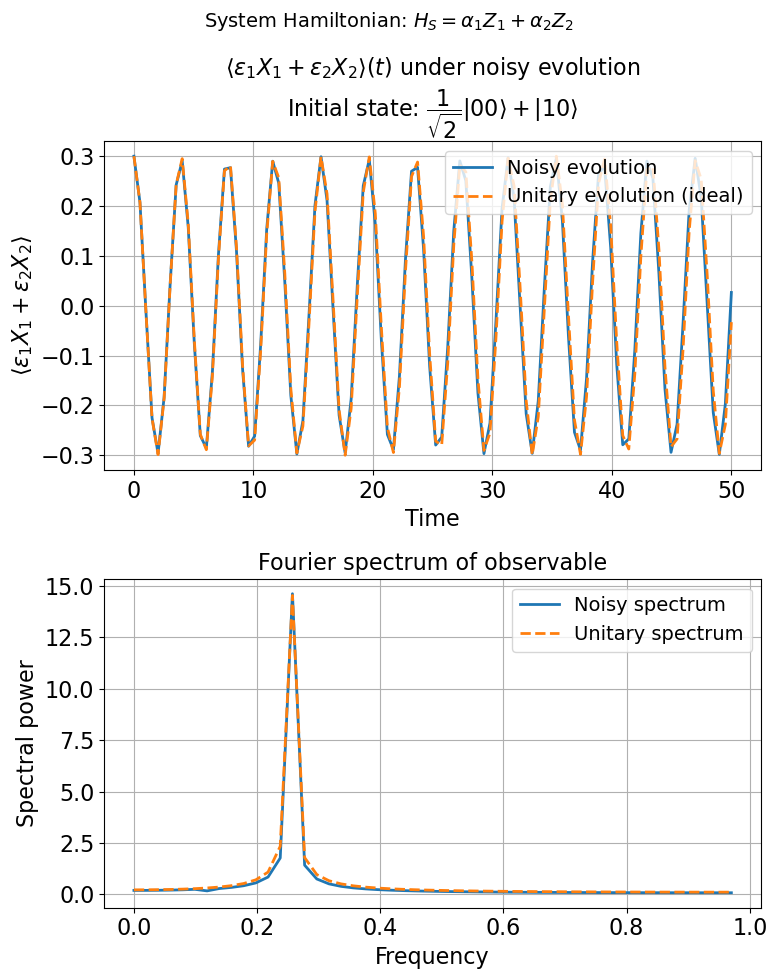

The dominant frequency from the Fourier transform is: 0.2574 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.2574 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [27]:


import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
from scipy.signal import find_peaks



# Parameters

g = 0.05
num_modes_per_bath = 2
N = 2  # Fock space truncation
kappa = 0.1
tlist = np.linspace(0, 50, 100)
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\2QUBITS" #To save the images
num_qubits = 2  # Number of qubits

# Function to build local operators embedded in full Hilbert space
def build_op(op_qubit, pos):
    ops = [qeye(2) for _ in range(num_qubits)] + [qeye(N) for _ in range(num_qubits * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)

# Pauli operators in the full Hilbert space
X1_full = build_op(sigmax(), 0)
X2_full = build_op(sigmax(), 1)
Z1_full = build_op(sigmaz(), 0)
Z2_full = build_op(sigmaz(), 1)

# Bath creation/annihilation operators
a_ops = []
for i in range(num_qubits * num_modes_per_bath):
    ops = [qeye(2) for _ in range(num_qubits)] + [destroy(N) if j == i else qeye(N) for j in range(num_qubits * num_modes_per_bath)]
    a_ops.append(tensor(ops))

# Random coefficients for ε₁ and ε₂
epsilon1=0.3
epsilon2=1.2
alpha1 = 0.8
alpha2 = 0.7
# System Hamiltonian: H_S = Z₁ + Z₂
Hs = alpha1* Z1_full + alpha2*Z2_full

# Bath Hamiltonian
# Assign different omega_i to each bath mode
omega_list = np.random.uniform(0.5, 2.0, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(2):
    X = build_op(sigmax(), qubit)
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * X * (a + a.dag())

# Total Hamiltonian
H_total = Hs + Hb + Hsb

# Initial state of the full system: (|00⟩ + |11⟩)/√2 ⊗ |0⟩_bath
zero0 = tensor(basis(2, 0), basis(2, 0), *[basis(N, 0) for _ in range(2 * num_modes_per_bath)])
one1 = tensor(basis(2, 1), basis(2, 0), *[basis(N, 0) for _ in range(2 * num_modes_per_bath)])

psi= zero0 + one1
psi = psi.unit()  # Normalize the state

    
# Evolution with noise (open system)
result_noisy = mesolve(H_total, psi, tlist, [])

# Evolution without noise (unitary)
result_unitary = sesolve(Hs, psi, tlist)

# Reduced observable: ε₁ x₁ + ε₂ x₂ on the 2-qubit system
X1 = tensor(sigmax(), qeye(2))
X2 = tensor(qeye(2), sigmax())
observable_op = epsilon1 * X1 + epsilon2 * X2

# Compute expectation values with normalization of reduced density matrices
observable_noisy = []
observable_unitary = []

for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):

    #For the ideal case
    rho_unitary = unitary_state.ptrace([0, 1])
    rho_unitary = rho_unitary / rho_unitary.tr()
    val_unitary = expect(observable_op, rho_unitary)
    observable_unitary.append(val_unitary)
    rho_noisy = noisy_state.ptrace([0, 1])
    rho_noisy = rho_noisy / rho_noisy.tr()
    val_noisy = expect(observable_op, rho_noisy)
    observable_noisy.append(val_noisy)

# Fourier Transform of energy from noisy expectation values
energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Fourier Transform of energy from unitary expectation values
energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
freqs_noisy = freqs_unitary = freqs
spectrum_noisy = energy_noisy_fft
spectrum_unitary = energy_unitary_fft

# Plot observable and its Fourier spectrum side by side
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(r'System Hamiltonian: $H_S = \alpha_1 Z_1 +\alpha_2 Z_2$', fontsize=14, y=y)

# Left: Observable ⟨ε₁ Z₁ + ε₂ Z₂⟩
axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution (ideal)', lw=2, color='tab:orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 X_1 + \epsilon_2 X_2 \rangle$')
axs[0].set_title(
    r'$\langle \epsilon_1 X_1 + \epsilon_2 X_2 \rangle(t)$ under noisy evolution' '\n'
    r'Initial state: $ \dfrac{1}{\sqrt{2}}|00\rangle + |10\rangle $'

)
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs_noisy >= 0

freqs_noisy= freqs_noisy[pos_mask]
freqs_unitary = freqs_unitary[pos_mask]
spectrum_noisy = spectrum_noisy[pos_mask]
spectrum_unitary = spectrum_unitary[pos_mask]
axs[1].plot(freqs_noisy, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
axs[1].plot(freqs_unitary, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].grid(True)
name = "Z1_Z2"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path,name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(spectrum_noisy)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs_noisy[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(spectrum_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary = freqs_unitary[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

## 3 qubits

### X1+X2+X3

\begin{equation}
H_S = \alpha_1X_1+ \alpha_2X_2 + \alpha_3X_3
\end{equation}

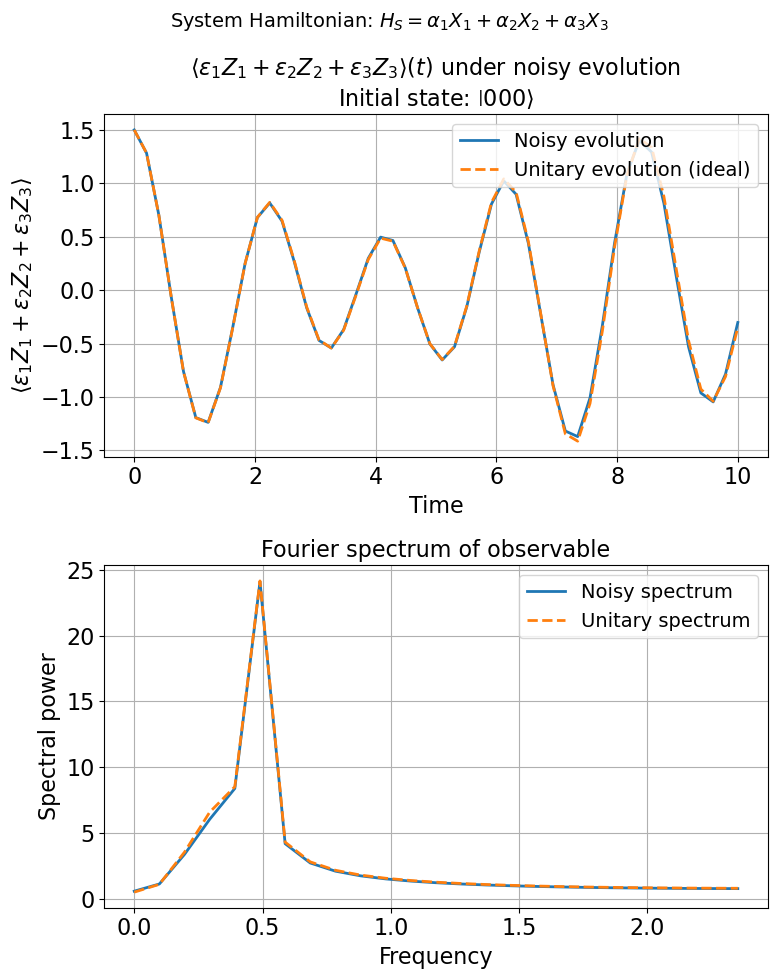

The dominant frequency from the Fourier transform is: 0.4900 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.4900 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [28]:


import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
np.random.seed(42)

# Parameters
g = 0.05
num_modes_per_bath = 1
N = 2  # Fock space truncation
kappa = 0.05
tlist = np.linspace(0, 10, 50)
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\3QUBITS" #To save the images


def build_op(op_qubit, pos):
    ops = [qeye(2) for _ in range(3)] + [qeye(N) for _ in range(3 * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)

# Pauli operators in the full Hilbert space
X1_full = build_op(sigmax(), 0)
X2_full = build_op(sigmax(), 1)
X3_full = build_op(sigmax(), 2)
Z1_full = build_op(sigmaz(), 0)
Z2_full = build_op(sigmaz(), 1)
Z3_full = build_op(sigmaz(), 2)


# Bath creation/annihilation operators
a_ops = []
for i in range(3 * num_modes_per_bath):
    ops = [qeye(2), qeye(2), qeye(2)] + [destroy(N) if j == i else qeye(N) for j in range(3 * num_modes_per_bath)]
    a_ops.append(tensor(ops))

# Random coefficients for ε₁, ε₂, and ε₃
epsilon1= 0.1
epsilon2= 0.5
epsilon3= 0.9
alpha1 = 0.7
alpha2 = 1.1
alpha3 = 1.5

# Observable operators in the full Hilbert space
Z1 = tensor(sigmaz(), qeye(2), qeye(2))
Z2 = tensor(qeye(2), sigmaz(), qeye(2))
Z3 = tensor(qeye(2), qeye(2), sigmaz())
observable_op= epsilon1 * Z1 + epsilon2 * Z2 + epsilon3 * Z3

# System Hamiltonian: H_S = ε₁ X₁ + ε₂ X₂ + ε₃ X₃
Hs = alpha1 * X1_full + alpha2 * X2_full + alpha3 * X3_full

# Bath Hamiltonian
omega_list = np.random.uniform(0.5, 2.0, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(3):
    Z = build_op(sigmaz(), qubit)
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * Z * (a + a.dag())

# Total Hamiltonian
H_total = Hs + Hb + Hsb

# Initial state of the full system: (|00⟩ + |11⟩)/√2 ⊗ |0⟩_bath
zero0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0), *[basis(N, 0) for _ in range(3 * num_modes_per_bath)])
psi= zero0
    
# Evolution with noise (open system)
result_noisy = mesolve(H_total, psi, tlist, [])

# Evolution without noise (unitary)
result_unitary = sesolve(Hs, psi, tlist)


# Compute expectation values with normalization of reduced density matrices
observable_noisy = []
observable_unitary = []

for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):
    rho_noisy = noisy_state.ptrace([0, 1, 2])
    rho_noisy = rho_noisy / rho_noisy.tr()  # Normalize the reduced density matrix
    # Compute expectation value of the observable
    val_noisy = expect(observable_op, rho_noisy)
    # Append the value to the list
    observable_noisy.append(val_noisy)

    #For the ideal case
    rho_unitary = unitary_state.ptrace([0, 1,2])
    rho_unitary = rho_unitary / rho_unitary.tr()
    val_unitary = expect(observable_op, rho_unitary)
    observable_unitary.append(val_unitary)
    

# Fourier Transform of energy from noisy expectation values
energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Fourier Transform of energy from unitary expectation values
energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
freqs_noisy = freqs_unitary = freqs
spectrum_noisy = energy_noisy_fft
spectrum_unitary = energy_unitary_fft

# Plot observable and its Fourier spectrum side by side
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(r'System Hamiltonian: $H_S = \alpha_1 X_1 + \alpha_2X_2+ \alpha_3 X_3$', fontsize=14, y=y)

# Left: Observable ⟨ε₁ Z₁ + ε₂ Z₂⟩
axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution (ideal)', lw=2, color='tab:orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2+ \epsilon_3 Z_3 \rangle$')
axs[0].set_title(
    r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2+ \epsilon_3 Z_3 \rangle(t)$ under noisy evolution' '\n'
    r'Initial state: $ \left |000\right \rangle $'

)
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs_noisy >= 0

freqs_noisy= freqs_noisy[pos_mask]
freqs_unitary = freqs_unitary[pos_mask]
spectrum_noisy = spectrum_noisy[pos_mask]
spectrum_unitary = spectrum_unitary[pos_mask]
axs[1].plot(freqs_noisy, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
axs[1].plot(freqs_unitary, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].legend(loc='upper right')
axs[1].grid(True)
name = "X1_X2_X3"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path,name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(spectrum_noisy)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs_noisy[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(spectrum_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary = freqs_unitary[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

### X_1 * X_2 + Y_1 * Y_2 + X_2 * X_3 + Y_2 * Y_3

\begin{equation}
H_s= \alpha_1 X_1 * X_2 + \alpha_2Y_1 * Y_2 + \alpha_3X_2 * X_3 + \alpha_4Y_2 * Y_3
\end{equation}

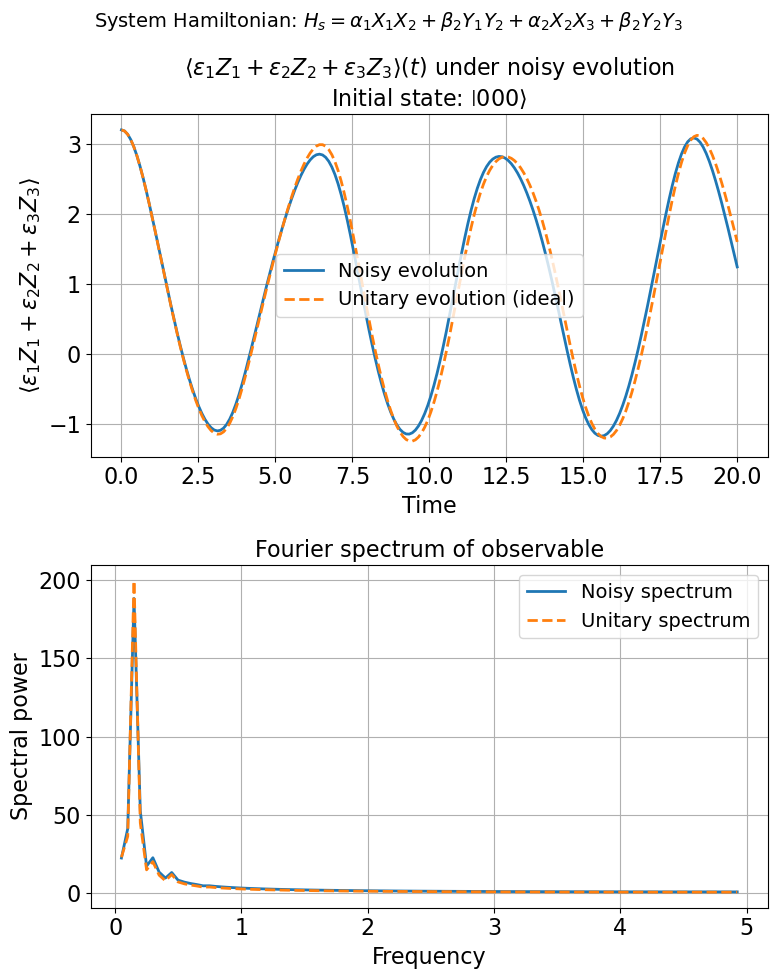

The dominant frequency from the Fourier transform is: 0.1492 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.1492 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [29]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
np.random.seed(42)

# Parameters
num_modes_per_bath = 1
g = 0.05
N = 3  # Fock space truncation
tlist = np.linspace(0, 20, 200)
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\3QUBITS" #To save the images


def build_op(op_qubit, pos):
    ops = [qeye(2) for _ in range(3)] + [qeye(N) for _ in range(3 * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)


# Pauli operators for qubits (full system)
X1_full = build_op(sigmax(), 0)
X2_full = build_op(sigmax(), 1)
X3_full = build_op(sigmax(), 2)
Y1_full = build_op(sigmay(), 0)
Y2_full = build_op(sigmay(), 1)
Y3_full = build_op(sigmay(), 2)
Z1_full = build_op(sigmaz(), 0)
Z2_full = build_op(sigmaz(), 1)
Z3_full = build_op(sigmaz(), 2)


# Bath creation/annihilation operators
a_ops = []
for i in range(3 * num_modes_per_bath):
    ops = [qeye(2), qeye(2), qeye(2)] + [destroy(N) if j == i else qeye(N) for j in range(3 * num_modes_per_bath)]
    a_ops.append(tensor(ops))

# Random coefficients for ε₁, ε₂, and ε₃
epsilon1= 1.1
epsilon2= 1.2
epsilon3= 0.9
epsilon4= 0.9
alpha1 = 0.7
alpha2 = 1.1
alpha3 = 1.1
beta1 = 0.8
beta2 = 0.5
beta3 = 0.9

# Observable operators in the full Hilbert space
Z1 = tensor(sigmaz(), qeye(2), qeye(2))
Z2 = tensor(qeye(2), sigmaz(), qeye(2))
Z3 = tensor(qeye(2), qeye(2), sigmaz())
observable_op= epsilon1 * Z1 + epsilon2 * Z2 + epsilon3 * Z3
# System Hamiltonian: H_S = X₁ X₂ + Y₁ Y₂ + X₂ X₃ + Y₂ Y₃ (extended to 3 qubits)
Hs = alpha1*X1_full * X2_full + beta1*Y1_full * Y2_full + alpha2*X2_full * X3_full + beta2*Y2_full * Y3_full

# Bath Hamiltonian
omega_list = np.random.uniform(0.5, 0.6, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(3):
    Z = build_op(sigmaz(), qubit)
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * Z * (a + a.dag())

# Total Hamiltonian
H_total = Hs + Hb + Hsb

# Initial state of the full system: (|00⟩ + |11⟩)/√2 ⊗ |0⟩_bath
zero0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0), *[basis(N, 0) for _ in range(3 * num_modes_per_bath)])
psi= zero0
    
# Evolution with noise (open system)
result_noisy = mesolve(H_total, psi, tlist, [])

# Evolution without noise (unitary)
result_unitary = sesolve(Hs, psi, tlist)


# Compute expectation values with normalization of reduced density matrices
observable_noisy = []
observable_unitary = []

for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):
    # Partial trace to single qubits
    rho_noisy= noisy_state.ptrace([0, 1, 2])
    # Normalize reduced single-qubit density matrices
    rho_noisy = rho_noisy / rho_noisy.tr()
    val_noisy = expect(observable_op, rho_noisy)

    observable_noisy.append(val_noisy)

    #For the ideal case
    rho_unitary = unitary_state.ptrace([0, 1,2])
    rho_unitary = rho_unitary / rho_unitary.tr()
    val_unitary = expect(observable_op, rho_unitary)
    observable_unitary.append(val_unitary)
    

# Fourier Transform of energy from noisy expectation values
energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Fourier Transform of energy from unitary expectation values
energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
freqs_noisy = freqs_unitary = freqs
spectrum_noisy = energy_noisy_fft
spectrum_unitary = energy_unitary_fft

# Plot observable and its Fourier spectrum side by side
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(r'System Hamiltonian: $H_s= \alpha_1 X_1X_2 + \beta_2 Y_1Y_2 +\alpha_2 X_2 X_3 + \beta_2 Y_2 Y_3$', fontsize=14, y=y )

# Left: Observable ⟨ε₁ Z₁ + ε₂ Z₂⟩
axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution (ideal)', lw=2, color='tab:orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2+ \epsilon_3 Z_3 \rangle$')
axs[0].set_title(
    r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2+ \epsilon_3 Z_3 \rangle(t)$ under noisy evolution' '\n'
    r'Initial state: $ \left |000\right \rangle $'

)
axs[0].legend()
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs_noisy > 0


freqs_noisy= freqs_noisy[pos_mask]
freqs_unitary = freqs_unitary[pos_mask]
spectrum_noisy = spectrum_noisy[pos_mask]
spectrum_unitary = spectrum_unitary[pos_mask]
axs[1].plot(freqs_noisy, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
axs[1].plot(freqs_unitary, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].legend()
axs[1].grid(True)
name = "X1X2_Y1Y2_X2X3_Y2Y3"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path,name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(spectrum_noisy)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs_noisy[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(spectrum_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary = freqs_unitary[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

### Z1+Z2+Z3

\begin{equation}
H_S = \alpha_1Z_1+ \alpha_2Z_2 + \alpha_3Z_3
\end{equation}

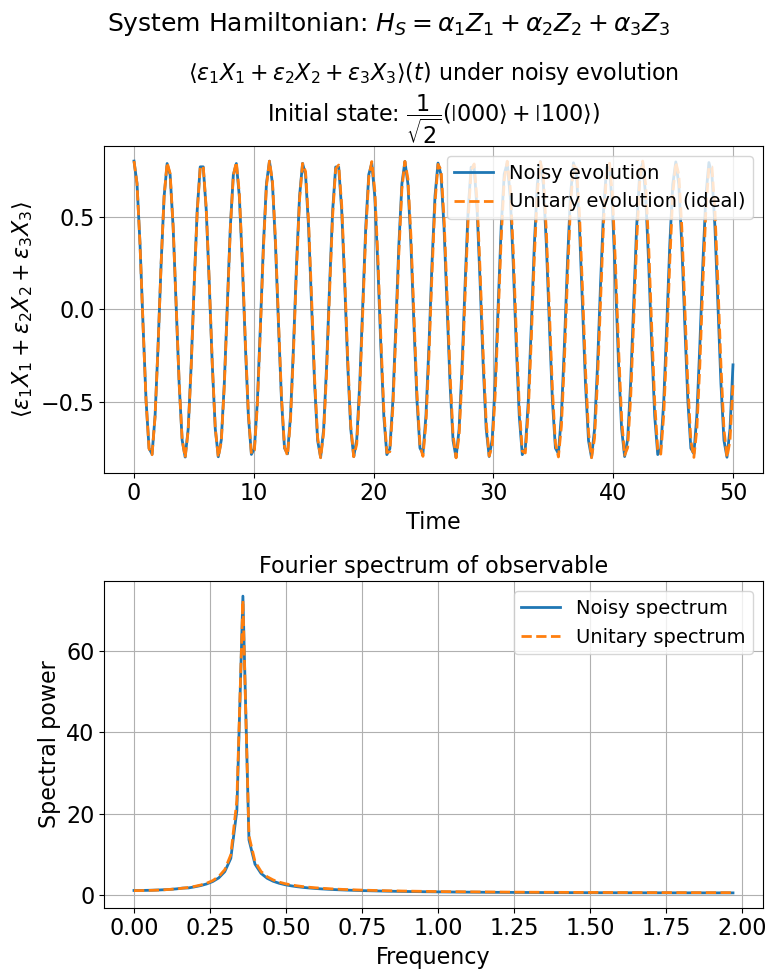

The dominant frequency from the Fourier transform is: 0.3582 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.3582 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [30]:


import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
np.random.seed(42)

# Parameters
g = 0.05
num_modes_per_bath = 1
N = 2  # Fock space truncation
kappa = 0.01
tlist = np.linspace(0, 50, 200)
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\3QUBITS" #To save the images


def build_op(op_qubit, pos):
    ops = [qeye(2) for _ in range(3)] + [qeye(N) for _ in range(3 * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)

# Pauli operators in the full Hilbert space
X1_full = build_op(sigmax(), 0)
X2_full = build_op(sigmax(), 1)
X3_full = build_op(sigmax(), 2)
Z1_full = build_op(sigmaz(), 0)
Z2_full = build_op(sigmaz(), 1)
Z3_full = build_op(sigmaz(), 2)


# Bath creation/annihilation operators
a_ops = []
for i in range(3 * num_modes_per_bath):
    ops = [qeye(2), qeye(2), qeye(2)] + [destroy(N) if j == i else qeye(N) for j in range(3 * num_modes_per_bath)]
    a_ops.append(tensor(ops))

# Random coefficients for ε₁, ε₂, and ε₃
epsilon1= 0.8
epsilon2= 0.5
epsilon3= 0.9
alpha1 = 1.11
alpha2 = 1.1
alpha3 = 1.2

# Observable operators in the full Hilbert space
X1 = tensor(sigmax(), qeye(2), qeye(2))
X2 = tensor(qeye(2), sigmax(), qeye(2))
X3 = tensor(qeye(2), qeye(2), sigmax())
observable_op= epsilon1 * X1 + epsilon2 * X2 + epsilon3  *X3

# System Hamiltonian: H_S = ε₁ Z₁ + ε₂ Z₂ + ε₃ Z₃
Hs = alpha1 * Z1_full + alpha2 * Z2_full + alpha3 * Z3_full

# Bath Hamiltonian
omega_list = np.random.uniform(0.5, 2, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(3):
    X = build_op(sigmax(), qubit)
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * X * (a + a.dag())

# Total Hamiltonian
H_total = Hs + Hb + Hsb

# Initial state of the full system: (|00⟩ + |11⟩)/√2 ⊗ |0⟩_bath
zero0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0), *[basis(N, 0) for _ in range(3 * num_modes_per_bath)])
one1 = tensor(basis(2, 1), basis(2, 0), basis(2, 0), *[basis(N, 0) for _ in range(3 * num_modes_per_bath)])
psi= zero0+ one1
psi = psi.unit()  # Normalize the state
    
# Evolution with noise (open system)
result_noisy = mesolve(H_total, psi, tlist, [])

# Evolution without noise (unitary)
result_unitary = sesolve(Hs, psi, tlist)


# Compute expectation values with normalization of reduced density matrices
observable_noisy = []
observable_unitary = []

for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):

    rho_unitary = unitary_state.ptrace([0, 1,2])
    rho_unitary = rho_unitary / rho_unitary.tr()
    val_unitary = expect(observable_op, rho_unitary)
    observable_unitary.append(val_unitary)
    rho_noisy = noisy_state.ptrace([0, 1,2])
    rho_noisy = rho_noisy / rho_noisy.tr()
    val_noisy = expect(observable_op, rho_noisy)
    observable_noisy.append(val_noisy)

# Fourier Transform of energy from noisy expectation values
energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Fourier Transform of energy from unitary expectation values
energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
freqs_noisy = freqs_unitary = freqs
spectrum_noisy = energy_noisy_fft
spectrum_unitary = energy_unitary_fft

# Plot observable and its Fourier spectrum side by side
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(r'System Hamiltonian: $H_S = \alpha_1 Z_1 + \alpha_2Z_2+ \alpha_3 Z_3$', fontsize=18, y=y)

# Left: Observable ⟨ε₁ Z₁ + ε₂ Z₂⟩
axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution (ideal)', lw=2, color='tab:orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 X_1 + \epsilon_2 X_2+ \epsilon_3 X_3 \rangle$')
axs[0].set_title(
    r'$\langle \epsilon_1 X_1 + \epsilon_2 X_2+ \epsilon_3 X_3 \rangle(t)$ under noisy evolution' '\n'
    r'Initial state: $  \dfrac {1}{\sqrt{2}} (\left |000\right \rangle+\left |100\right \rangle) $'

)
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs_noisy >= 0

freqs_noisy= freqs_noisy[pos_mask]
freqs_unitary = freqs_unitary[pos_mask]
spectrum_noisy = spectrum_noisy[pos_mask]
spectrum_unitary = spectrum_unitary[pos_mask]
axs[1].plot(freqs_noisy, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
axs[1].plot(freqs_unitary, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].legend(loc='upper right')
axs[1].grid(True)
name = "Z1_Z2_Z3"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path,name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(spectrum_noisy)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs_noisy[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(spectrum_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary = freqs_unitary[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

## 4 Qubits

### $\alpha_1 X_1 + \alpha_2 X_2 + \alpha_3 X_3 + \alpha_4 X_4$

\begin{equation}
H_S = \alpha_1 X_1 + \alpha_2 X_2 + \alpha_3 X_3 + \alpha_4 X_4
\end{equation}

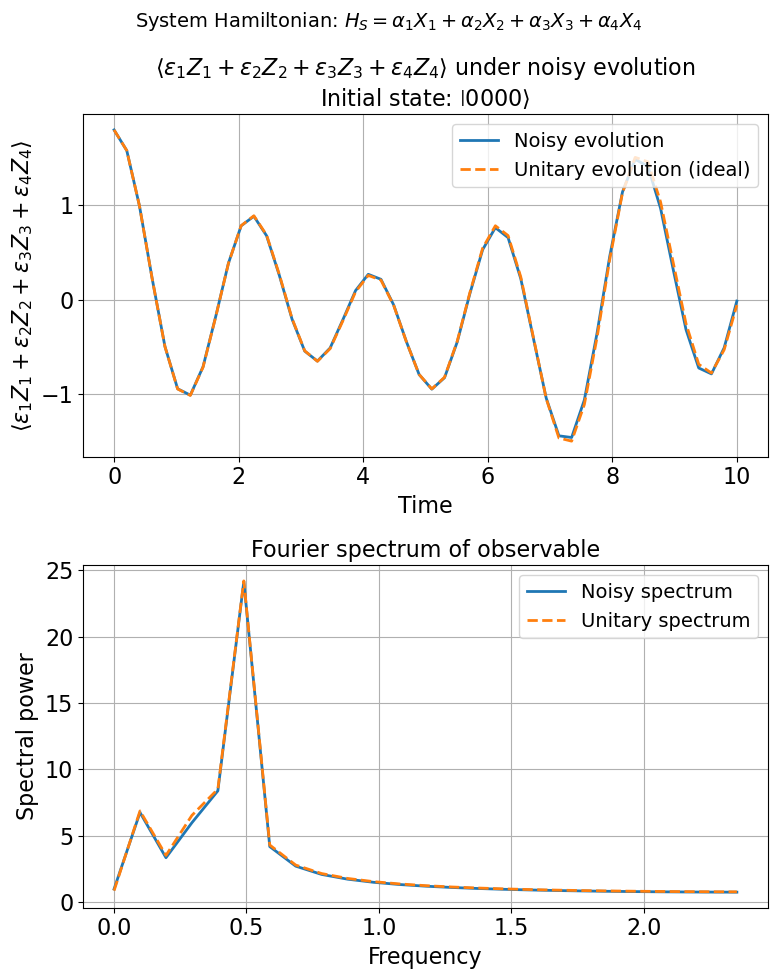

The dominant frequency from the Fourier transform is: 0.4900 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.4900 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [31]:


import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
np.random.seed(42)

# Parameters
num_qubits = 4
g = 0.05
num_modes_per_bath = 1
N = 2  # Fock space truncation
kappa = 0.05
tlist = np.linspace(0, 10, 50)
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\4QUBITS" #To save the images


def build_op(op_qubit, pos):
    ops = [qeye(2) for _ in range(num_qubits)] + [qeye(N) for _ in range(num_qubits * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)

# Pauli operators in the full Hilbert space
X1_full = build_op(sigmax(), 0)
X2_full = build_op(sigmax(), 1)
X3_full = build_op(sigmax(), 2)
X4_full = build_op(sigmax(), 3)
Y1_full = build_op(sigmay(), 0)
Z1_full = build_op(sigmaz(), 0)
Z2_full = build_op(sigmaz(), 1)
Z3_full = build_op(sigmaz(), 2)
Z4_full = build_op(sigmaz(), 3)


# Bath creation/annihilation operators
a_ops = []
for i in range(num_qubits * num_modes_per_bath):
    ops = [qeye(2) for _ in range(num_qubits)] + [destroy(N) if j == i else qeye(N) for j in range(num_qubits * num_modes_per_bath)]
    a_ops.append(tensor(ops))

# Random coefficients for ε₁, ε₂, and ε₃
epsilon1= 0.1
epsilon2= 0.5
epsilon3= 0.9
epsilon4= 0.3
alpha1 = 0.7
alpha2 = 1.1
alpha3 = 1.5
alpha4 = 0.3

# Observable operators in the full Hilbert space
Z1 = tensor(sigmaz(), qeye(2), qeye(2), qeye(2))
Z2 = tensor(qeye(2), sigmaz(), qeye(2), qeye(2))
Z3 = tensor(qeye(2), qeye(2), sigmaz(), qeye(2))
Z4 = tensor(qeye(2), qeye(2), qeye(2), sigmaz())
observable_op= epsilon1 * Z1 + epsilon2 * Z2 + epsilon3 * Z3 + epsilon4 * Z4

# System Hamiltonian
Hs = alpha1 * X1_full + alpha2 * X2_full + alpha3 * X3_full + alpha4 * X4_full

# Bath Hamiltonian
omega_list = np.random.uniform(0.5, 2.0, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(num_qubits):
    Z = build_op(sigmaz(), qubit)
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * Z * (a + a.dag())

# Total Hamiltonian
H_total = Hs + Hb + Hsb

# Initial state of the full system
zero0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0),basis(2, 0), *[basis(N, 0) for _ in range(num_qubits * num_modes_per_bath)])
psi = zero0




# Evolution with noise (open system)
result_noisy = mesolve(H_total, psi, tlist, [])

# Evolution without noise (unitary)
result_unitary = sesolve(Hs, psi, tlist)


# Compute expectation values with normalization of reduced density matrices
observable_noisy = []
observable_unitary = []

for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):
    # Partial trace to single qubits
    rho_noisy_0 = noisy_state.ptrace(0)
    rho_noisy_1 = noisy_state.ptrace(1)
    rho_noisy_2 = noisy_state.ptrace(2)
    rho_noisy_3 = noisy_state.ptrace(3)
    # Normalize reduced single-qubit density matrices
    rho_noisy_0 = rho_noisy_0 / rho_noisy_0.tr()
    rho_noisy_1 = rho_noisy_1 / rho_noisy_1.tr()
    rho_noisy_2 = rho_noisy_2 / rho_noisy_2.tr()
    rho_noisy_3 = rho_noisy_3 / rho_noisy_3.tr()
    # Probability of |1> state for each qubit (population element [1,1])
    p_noisy_0 = rho_noisy_0[1, 1].real
    p_noisy_1 = rho_noisy_1[1, 1].real
    p_noisy_2 = rho_noisy_2[1, 1].real
    p_noisy_3 = rho_noisy_3[1, 1].real
    # Your formula for expectation value
    val_noisy = epsilon1 * (1 - 2 * p_noisy_0) + epsilon2 * (1 - 2 * p_noisy_1)+ epsilon3 * (1 - 2 * p_noisy_2)+ epsilon4 * (1 - 2 * p_noisy_3)

    observable_noisy.append(val_noisy)

    #For the ideal case
    rho_unitary = unitary_state.ptrace([0, 1,2,3])
    rho_unitary = rho_unitary / rho_unitary.tr()
    val_unitary = expect(observable_op, rho_unitary)
    observable_unitary.append(val_unitary)
    

# Fourier Transform of energy from noisy expectation values
energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Fourier Transform of energy from unitary expectation values
energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
freqs_noisy = freqs_unitary = freqs
spectrum_noisy = energy_noisy_fft
spectrum_unitary = energy_unitary_fft

# Plot observable and its Fourier spectrum side by side
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(r'System Hamiltonian: $H_S = \alpha_1 X_1 + \alpha_2X_2+ \alpha_3 X_3+ \alpha_4X_4$', fontsize=14, y=y)

# Left: Observable ⟨ε₁ Z₁ + ε₂ Z₂⟩
axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution (ideal)', lw=2, color='tab:orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 + \epsilon_3 Z_3 + \epsilon_4 Z_4\rangle$')
axs[0].set_title(
    r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 + \epsilon_3 Z_3 + \epsilon_4 Z_4\rangle$ under noisy evolution' '\n'
   r'Initial state: $ \left |0000\right \rangle $'

)
axs[0].legend(loc='upper right')
axs[0].grid(True)


# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs_noisy >= 0

freqs_noisy= freqs_noisy[pos_mask]
freqs_unitary = freqs_unitary[pos_mask]
spectrum_noisy = spectrum_noisy[pos_mask]
spectrum_unitary = spectrum_unitary[pos_mask]
axs[1].plot(freqs_noisy, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
axs[1].plot(freqs_unitary, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].legend(loc='upper right')
axs[1].grid(True)
name = "X1_X2_X3_X4"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path,name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(spectrum_noisy)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs_noisy[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(spectrum_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary = freqs_unitary[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

### $\alpha_1 X_1 X_2 + \alpha_2 Y_1 Y_2 + \alpha_3 X_2 X_3 + \alpha_4 Y_2 Y_3 + \alpha_5 X_3 X_4 + \alpha_6 Y_3 Y_4$

\begin{equation}
H_S = \alpha_1 X_1 X_2 + \alpha_2 Y_1 Y_2 + \alpha_3 X_2 X_3 + \alpha_4 Y_2 Y_3 + \alpha_5 X_3 X_4 + \alpha_6 Y_3 Y_4
\end{equation}

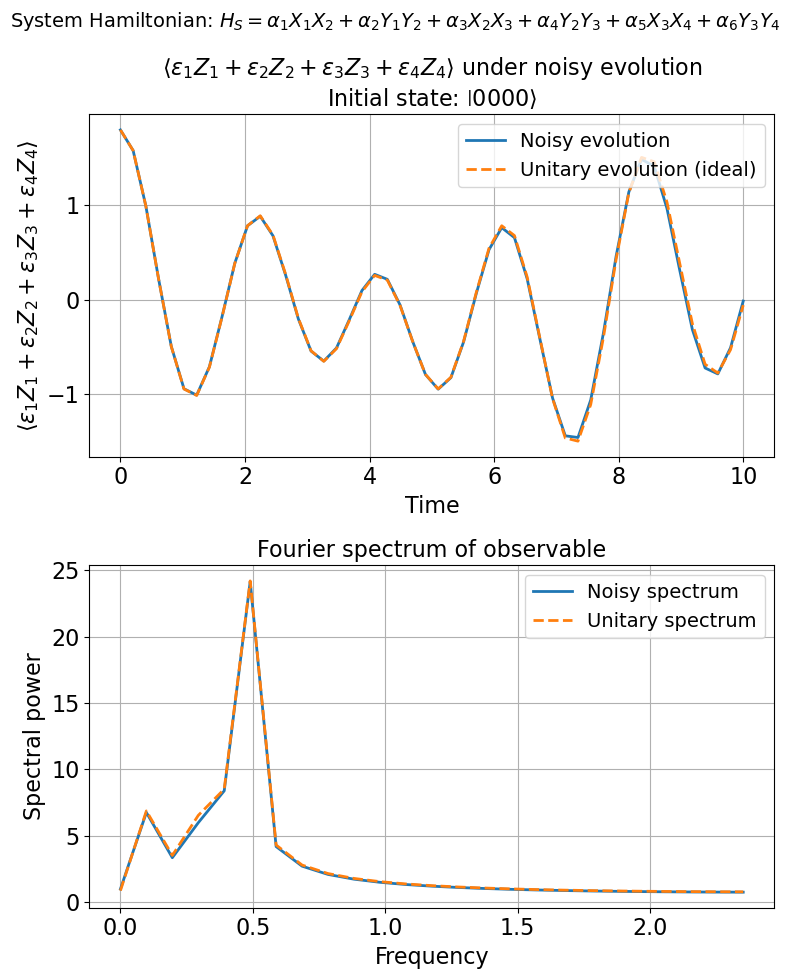

The dominant frequency from the Fourier transform is: 0.4900 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.4900 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [32]:


import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
np.random.seed(42)

# Parameters
num_qubits = 4
g = 0.05
num_modes_per_bath = 1
N = 2  # Fock space truncation
kappa = 0.05
tlist = np.linspace(0, 10, 50)
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\4QUBITS" #To save the images


def build_op(op_qubit, pos):
    ops = [qeye(2) for _ in range(num_qubits)] + [qeye(N) for _ in range(num_qubits * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)

# Pauli operators in the full Hilbert space
X1_full = build_op(sigmax(), 0)
X2_full = build_op(sigmax(), 1)
X3_full = build_op(sigmax(), 2)
X4_full = build_op(sigmax(), 3)
Y1_full = build_op(sigmay(), 0)
Y2_full = build_op(sigmay(), 1)
Y3_full = build_op(sigmay(), 2)
Y4_full = build_op(sigmay(), 3)

Z1_full = build_op(sigmaz(), 0)
Z2_full = build_op(sigmaz(), 1)
Z3_full = build_op(sigmaz(), 2)
Z4_full = build_op(sigmaz(), 3)


# Bath creation/annihilation operators
a_ops = []
for i in range(num_qubits * num_modes_per_bath):
    ops = [qeye(2) for _ in range(num_qubits)] + [destroy(N) if j == i else qeye(N) for j in range(num_qubits * num_modes_per_bath)]
    a_ops.append(tensor(ops))

# Random coefficients for ε₁, ε₂, and ε₃
epsilon1= 0.1
epsilon2= 0.5
epsilon3= 0.9
epsilon4= 0.3
alpha1 = 0.7
alpha2 = 1.1
alpha3 = 1.5
alpha4 = 0.3
alpha5 = 0.5
alpha6 = 0.9
# Observable operators in the full Hilbert space
Z1 = tensor(sigmaz(), qeye(2), qeye(2), qeye(2))
Z2 = tensor(qeye(2), sigmaz(), qeye(2), qeye(2))
Z3 = tensor(qeye(2), qeye(2), sigmaz(), qeye(2))
Z4 = tensor(qeye(2), qeye(2), qeye(2), sigmaz())

observable_op= epsilon1 * Z1 + epsilon2 * Z2 + epsilon3 * Z3 + epsilon4 * Z4


# System Hamiltonian: H_S = ε₁ X₁ + ε₂ X₂ + ε₃ X₃
Hs = alpha1*X1_full * X2_full + alpha2*Y1_full * Y2_full + alpha3*X2_full * X3_full + alpha4*Y2_full * Y3_full +alpha5* X3_full * X4_full + alpha6* Y3_full * Y4_full


# System Hamiltonian
Hs = alpha1 * X1_full + alpha2 * X2_full + alpha3 * X3_full + alpha4 * X4_full

# Bath Hamiltonian
omega_list = np.random.uniform(0.5, 2.0, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(num_qubits):
    Z = build_op(sigmaz(), qubit)
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * Z * (a + a.dag())

# Total Hamiltonian
H_total = Hs + Hb + Hsb

# Initial state of the full system
zero0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0),basis(2, 0), *[basis(N, 0) for _ in range(num_qubits * num_modes_per_bath)])
psi = zero0




# Evolution with noise (open system)
result_noisy = mesolve(H_total, psi, tlist, [])

# Evolution without noise (unitary)
result_unitary = sesolve(Hs, psi, tlist)


# Compute expectation values with normalization of reduced density matrices
observable_noisy = []
observable_unitary = []

for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):
    # Partial trace to single qubits
    rho_noisy_0 = noisy_state.ptrace(0)
    rho_noisy_1 = noisy_state.ptrace(1)
    rho_noisy_2 = noisy_state.ptrace(2)
    rho_noisy_3 = noisy_state.ptrace(3)
    # Normalize reduced single-qubit density matrices
    rho_noisy_0 = rho_noisy_0 / rho_noisy_0.tr()
    rho_noisy_1 = rho_noisy_1 / rho_noisy_1.tr()
    rho_noisy_2 = rho_noisy_2 / rho_noisy_2.tr()
    rho_noisy_3 = rho_noisy_3 / rho_noisy_3.tr()
    # Probability of |1> state for each qubit (population element [1,1])
    p_noisy_0 = rho_noisy_0[1, 1].real
    p_noisy_1 = rho_noisy_1[1, 1].real
    p_noisy_2 = rho_noisy_2[1, 1].real
    p_noisy_3 = rho_noisy_3[1, 1].real
    # Your formula for expectation value
    val_noisy = epsilon1 * (1 - 2 * p_noisy_0) + epsilon2 * (1 - 2 * p_noisy_1)+ epsilon3 * (1 - 2 * p_noisy_2)+ epsilon4 * (1 - 2 * p_noisy_3)

    observable_noisy.append(val_noisy)

    #For the ideal case
    rho_unitary = unitary_state.ptrace([0, 1,2,3])
    rho_unitary = rho_unitary / rho_unitary.tr()
    val_unitary = expect(observable_op, rho_unitary)
    observable_unitary.append(val_unitary)
    

# Fourier Transform of energy from noisy expectation values
energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Fourier Transform of energy from unitary expectation values
energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
freqs_noisy = freqs_unitary = freqs
spectrum_noisy = energy_noisy_fft
spectrum_unitary = energy_unitary_fft

# Plot observable and its Fourier spectrum side by side
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(r'System Hamiltonian: $H_S = \alpha_1 X_1 X_2 + \alpha_2 Y_1 Y_2 + \alpha_3 X_2 X_3 + \alpha_4 Y_2 Y_3 + \alpha_5 X_3 X_4 + \alpha_6 Y_3 Y_4 $', fontsize=14, y=y)

# Left: Observable ⟨ε₁ Z₁ + ε₂ Z₂⟩
axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution (ideal)', lw=2, color='tab:orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 + \epsilon_3 Z_3 + \epsilon_4 Z_4\rangle$')
axs[0].set_title(
    r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 + \epsilon_3 Z_3 + \epsilon_4 Z_4\rangle$ under noisy evolution' '\n'
    r'Initial state: $ \left |0000\right \rangle $'

)
axs[0].legend(loc='upper right')
axs[0].grid(True)


# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs_noisy >= 0

freqs_noisy= freqs_noisy[pos_mask]
freqs_unitary = freqs_unitary[pos_mask]
spectrum_noisy = spectrum_noisy[pos_mask]
spectrum_unitary = spectrum_unitary[pos_mask]
axs[1].plot(freqs_noisy, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
axs[1].plot(freqs_unitary, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].legend(loc='upper right')
axs[1].grid(True)
name = "X1X2_Y1Y2_X2X3_Y2Y3_X3X4_Y3Y4"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path,name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(spectrum_noisy)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs_noisy[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(spectrum_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary = freqs_unitary[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

### $\alpha_1 Z_1 + \alpha_2 Z_2 + \alpha_3 Z_3 + \alpha_4 Z_4$

\begin{equation}
H_S = \alpha_1 Z_1 + \alpha_2 Z_2 + \alpha_3 Z_3 + \alpha_4 Z_4
\end{equation}

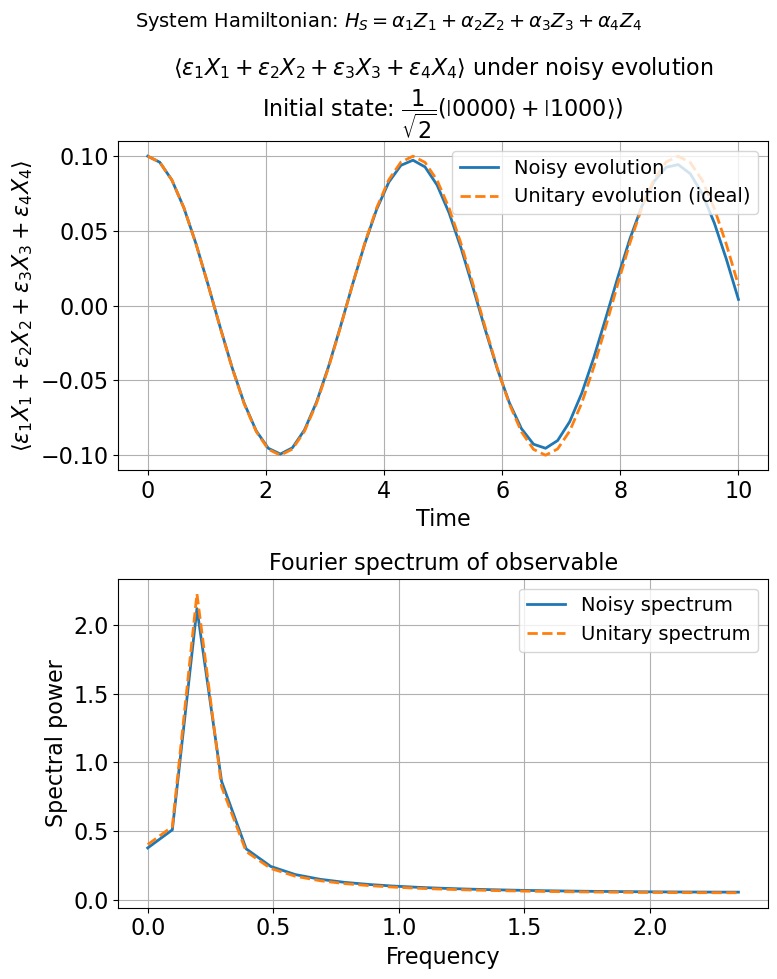

The dominant frequency from the Fourier transform is: 0.1960 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.1960 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [33]:


import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
np.random.seed(42)

# Parameters
num_qubits = 4
g = 0.05
num_modes_per_bath = 1
N = 2  # Fock space truncation
kappa = 0.05
tlist = np.linspace(0, 10, 50)
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\4QUBITS" #To save the images


def build_op(op_qubit, pos):
    ops = [qeye(2) for _ in range(num_qubits)] + [qeye(N) for _ in range(num_qubits * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)

# Pauli operators in the full Hilbert space
X1_full = build_op(sigmax(), 0)
X2_full = build_op(sigmax(), 1)
X3_full = build_op(sigmax(), 2)
X4_full = build_op(sigmax(), 3)
Y1_full = build_op(sigmay(), 0)
Z1_full = build_op(sigmaz(), 0)
Z2_full = build_op(sigmaz(), 1)
Z3_full = build_op(sigmaz(), 2)
Z4_full = build_op(sigmaz(), 3)


# Bath creation/annihilation operators
a_ops = []
for i in range(num_qubits * num_modes_per_bath):
    ops = [qeye(2) for _ in range(num_qubits)] + [destroy(N) if j == i else qeye(N) for j in range(num_qubits * num_modes_per_bath)]
    a_ops.append(tensor(ops))

# Random coefficients for ε₁, ε₂, and ε₃
epsilon1= 0.1
epsilon2= 0.5
epsilon3= 0.9
epsilon4= 0.3
alpha1 = 0.7
alpha2 = 1.1
alpha3 = 1.5
alpha4 = 0.3

# Observable operators in the full Hilbert space
X1 = tensor(sigmax(), qeye(2), qeye(2), qeye(2))
X2 = tensor(qeye(2), sigmax(), qeye(2), qeye(2))
X3 = tensor(qeye(2), qeye(2), sigmax(), qeye(2))
X4 = tensor(qeye(2), qeye(2), qeye(2), sigmax())
observable_op= epsilon1 * X1 + epsilon2 * X2 + epsilon3 * X3 + epsilon4 * X4

# System Hamiltonian
Hs = alpha1 * Z1_full + alpha2 * Z2_full + alpha3 * Z3_full + alpha4 * Z4_full

# Bath Hamiltonian
omega_list = np.random.uniform(0.5, 2.0, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(num_qubits):
    X = build_op(sigmax(), qubit)
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * X * (a + a.dag())

# Total Hamiltonian
H_total = Hs + Hb + Hsb

# Initial state of the full system
zero0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0),basis(2, 0), *[basis(N, 0) for _ in range(num_qubits * num_modes_per_bath)])
one1 = tensor(basis(2, 1), basis(2, 0), basis(2, 0),basis(2, 0), *[basis(N, 0) for _ in range(num_qubits * num_modes_per_bath)])
psi= zero0+ one1
psi = psi.unit()  # Normalize the state




# Evolution with noise (open system)
result_noisy = mesolve(H_total, psi, tlist, [])

# Evolution without noise (unitary)
result_unitary = sesolve(Hs, psi, tlist)


# Compute expectation values with normalization of reduced density matrices
observable_noisy = []
observable_unitary = []

for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):
    #For the ideal case
    rho_unitary = unitary_state.ptrace([0, 1,2,3])
    rho_unitary = rho_unitary / rho_unitary.tr()
    val_unitary = expect(observable_op, rho_unitary)
    observable_unitary.append(val_unitary)
    rho_noisy = noisy_state.ptrace([0, 1,2,3])
    rho_noisy = rho_noisy / rho_noisy.tr()
    val_noisy = expect(observable_op, rho_noisy)
    observable_noisy.append(val_noisy)
    

# Fourier Transform of energy from noisy expectation values
energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Fourier Transform of energy from unitary expectation values
energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
freqs_noisy = freqs_unitary = freqs
spectrum_noisy = energy_noisy_fft
spectrum_unitary = energy_unitary_fft

# Plot observable and its Fourier spectrum side by side
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(r'System Hamiltonian: $H_S = \alpha_1 Z_1 + \alpha_2Z_2+ \alpha_3 Z_3+ \alpha_4Z_4$', fontsize=14, y=y)

# Left: Observable ⟨ε₁ Z₁ + ε₂ Z₂⟩
axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution (ideal)', lw=2, color='tab:orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 X_1 + \epsilon_2 X_2 + \epsilon_3 X_3 + \epsilon_4 X_4\rangle$')
axs[0].set_title(
    r'$\langle \epsilon_1 X_1 + \epsilon_2 X_2 + \epsilon_3 X_3 + \epsilon_4 X_4\rangle$ under noisy evolution' '\n'
   r'Initial state: $ \dfrac {1}{\sqrt{2}} (\left |0000\right \rangle+\left |1000\right \rangle) $'

)
axs[0].legend(loc='upper right')
axs[0].grid(True)


# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs_noisy >= 0

freqs_noisy= freqs_noisy[pos_mask]
freqs_unitary = freqs_unitary[pos_mask]
spectrum_noisy = spectrum_noisy[pos_mask]
spectrum_unitary = spectrum_unitary[pos_mask]
axs[1].plot(freqs_noisy, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
axs[1].plot(freqs_unitary, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].legend(loc='upper right')
axs[1].grid(True)
name = "Z1_Z2_Z3_Z4"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path,name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(spectrum_noisy)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs_noisy[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(spectrum_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary = freqs_unitary[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")


## N QUBIT CODE for Hsb Z, with bosonic bath

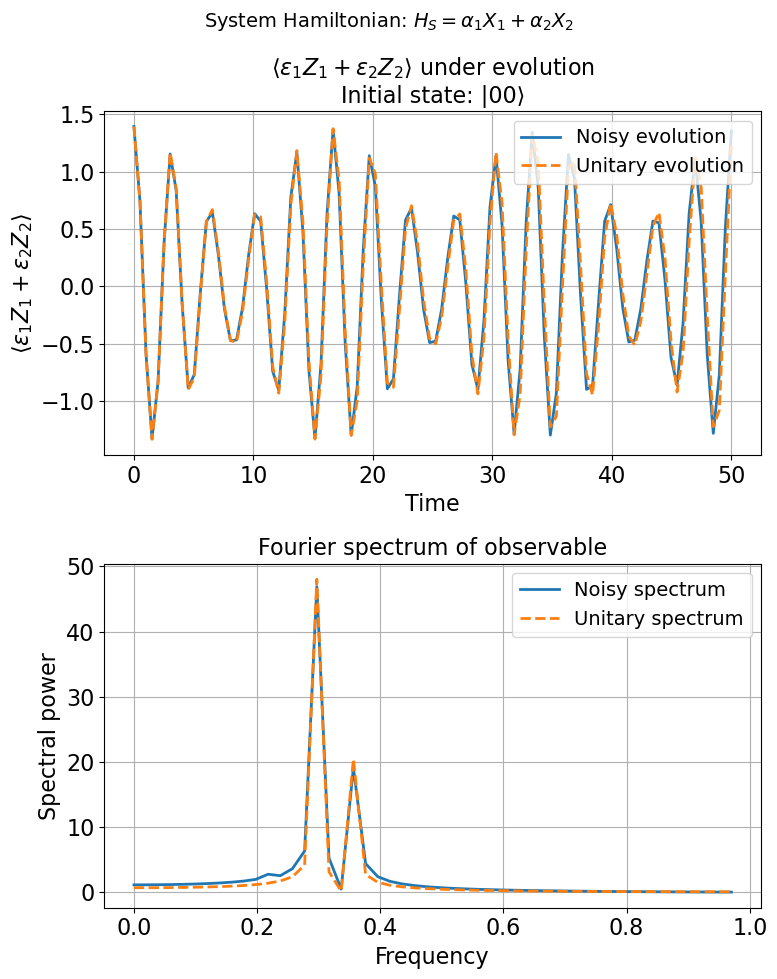

The dominant frequency from the Fourier transform is: 0.2970 (units of 1/time)


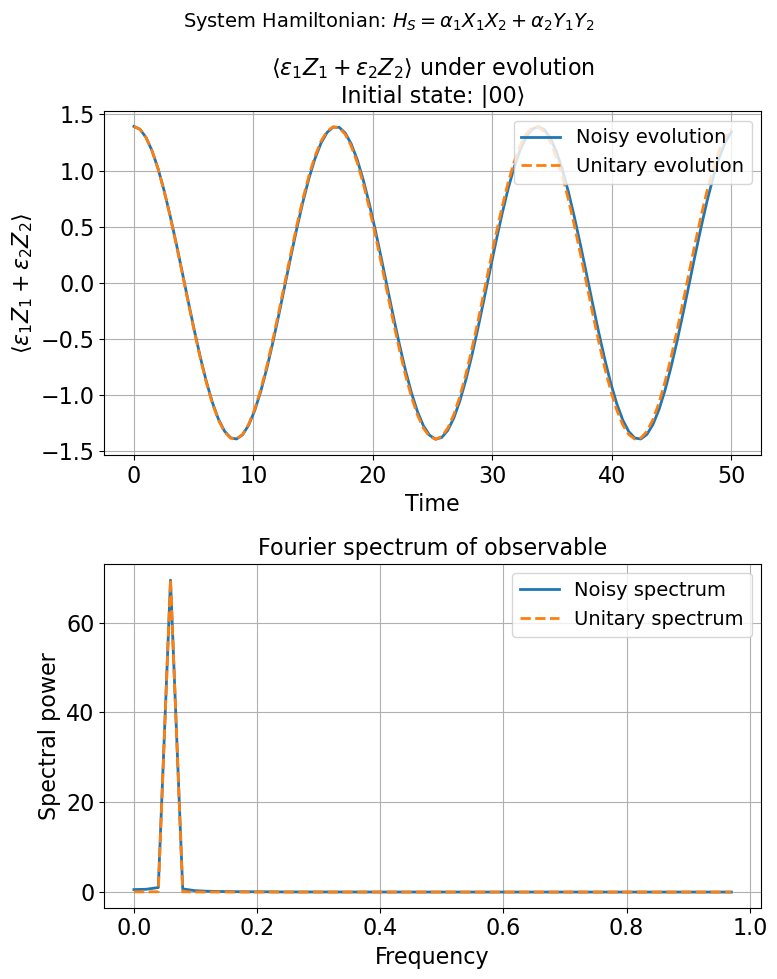

The dominant frequency from the Fourier transform is: 0.0594 (units of 1/time)


In [34]:


import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
np.random.seed(42)

# Parameters - USER CAN CHANGE THESE
num_qubits = 2  # Change this to the desired number of qubits
g = 0.05
num_modes_per_bath = 1
N = 2  # Fock space truncation
kappa = 0.05
tlist = np.linspace(0, 50, 100)
save_base_path = rf"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\{num_qubits}QUBITS"
# Generate random coefficients for the Hamiltonian and observable
epsilon = np.random.uniform(0.1, 1.0, num_qubits)  # Coefficients for observable
alpha = np.random.uniform(0.1, 1.5, 2*num_qubits+1)  # Coefficients for system Hamiltonian


def build_op(op_qubit, pos):
    """Build an operator acting on position 'pos' in the full Hilbert space"""
    ops = [qeye(2) for _ in range(num_qubits)] + [qeye(N) for _ in range(num_qubits * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)

# Create Pauli operators for all qubits
X_ops = [build_op(sigmax(), i) for i in range(num_qubits)]
Y_ops = [build_op(sigmay(), i) for i in range(num_qubits)]
Z_ops = [build_op(sigmaz(), i) for i in range(num_qubits)]

# Bath creation/annihilation operators
a_ops = []
for i in range(num_qubits * num_modes_per_bath):
    ops = [qeye(2) for _ in range(num_qubits)] + [destroy(N) if j == i else qeye(N) for j in range(num_qubits * num_modes_per_bath)]
    a_ops.append(tensor(ops))


# Observable operator acting only on the qubits' Hilbert space
Z_ops_qubits = [tensor([sigmaz() if j == i else qeye(2) for j in range(num_qubits)]) for i in range(num_qubits)]
observable_op = sum(epsilon[i] * Z_ops_qubits[i] for i in range(num_qubits))


# System Hamiltonian: Nearest-neighbor XX and YY interactions
Hs_1 = 0
for i in range(num_qubits):
    Hs_1 += alpha[i]* X_ops[i]
Hs_2 = 0
for i in range(num_qubits-1):
    Hs_2+= alpha[i] * X_ops[i] * X_ops[i+1]  # XX coupling
    Hs_2 += alpha[2*i+1] * Y_ops[i] * Y_ops[i+1]  # YY coupling

# Bath Hamiltonian
omega_list = np.random.uniform(0.5, 2.0, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(num_qubits):
    Z = Z_ops[qubit]
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * Z * (a + a.dag())

# Total Hamiltonian
H_total_1 = Hs_1 + Hb + Hsb
H_total_2 = Hs_2 + Hb + Hsb

# Initial state: all qubits in |0⟩ and all bath modes in vacuum
zero_state = tensor([basis(2, 0) for _ in range(num_qubits)] + [basis(N, 0) for _ in range(num_qubits * num_modes_per_bath)])
psi = zero_state.unit()

# Collapse operators (for open system evolution)
c_ops = [np.sqrt(kappa) * a for a in a_ops]

for i in range(2):
    if i == 0:
        H_total = H_total_1
        Hs = Hs_1
    else:
        if num_qubits == 1:
            print("For 1 qubit, only the first Hamiltonian is applicable.")
            continue
        else:
            H_total = H_total_2
            Hs = Hs_2

    # Evolution with noise (open system)
    result_noisy = mesolve(H_total, psi, tlist, [])

    # Evolution without noise (unitary)
    result_unitary = sesolve(Hs, psi, tlist)

    # Compute expectation values
    observable_noisy = []
    observable_unitary = []

    for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):
        # For noisy case: calculate expectation value using individual qubit populations
        val_noisy = 0
        for j in range(num_qubits):
            rho_noisy = noisy_state.ptrace(j)
            rho_noisy = rho_noisy / rho_noisy.tr()  # Normalize
            p_noisy = rho_noisy[1, 1].real  # Probability of |1⟩ state
            val_noisy += epsilon[j] * (1 - 2 * p_noisy)
        observable_noisy.append(val_noisy)

        # For unitary case: calculate expectation value directly
        rho_unitary = unitary_state.ptrace(list(range(num_qubits)))
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_unitary.append(val_unitary)

    # Fourier Transform
    energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
    energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
    freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

    # Select only positive frequencies
    pos_mask = freqs >= 0
    freqs = freqs[pos_mask]
    spectrum_noisy = energy_noisy_fft[pos_mask]
    spectrum_unitary = energy_unitary_fft[pos_mask]

    # Plotting
    if layout == 'vertical':
        fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    else:
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))


    # Create Hamiltonian title string
    if i == 0:
        ham_title = r'System Hamiltonian: $H_S = '
        for j in range(num_qubits):
            ham_title += fr'\alpha_{j+1} X_{j+1}'
            if j < num_qubits - 1:
                ham_title += ' + '
        ham_title += '$'
        title = ham_title.replace(r'\alpha', 'alpha').replace(r'\ ', '_').replace(' ', '_').replace('$', '').replace('{', '').replace('}', '')
    else:
        # For the second Hamiltonian with nearest-neighbor interactions
        ham_title = r'System Hamiltonian: $H_S = '
        for j in range(num_qubits - 1):
            ham_title += fr'\alpha_{2*j+1} X_{j+1} X_{j+2} + \alpha_{2*j+2} Y_{j+1} Y_{j+2}'
            if j < num_qubits - 2:
                ham_title += ' + '
            ham_title += '$'
        title = ham_title.replace(r'\alpha', 'alpha').replace(r'\ ', '_').replace(' ', '_').replace('$', '').replace('{', '').replace('}', '')
    
    # Left: Observable
    fig.suptitle(ham_title, fontsize=14, y=y)
    if num_qubits == 1:
        obs_label = r'$\langle ' + fr'\epsilon_1 Z_1 \rangle$'
    else:
        obs_label = r'$\langle ' + ' + '.join([fr'\epsilon_{i+1} Z_{i+1}' for i in range(num_qubits)]) + r'\rangle$'
    axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
    axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution', lw=2, color='tab:orange')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel(obs_label)
    axs[0].set_title(f'{obs_label} under evolution\nInitial state: |{"0"*num_qubits}⟩')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)

    # Right: Fourier spectrum
    axs[1].plot(freqs, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
    axs[1].plot(freqs, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Spectral power')
    axs[1].set_title('Fourier spectrum of observable')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)

    # Save and show
    name = f"{num_qubits}_{title}_general_code.png"
    os.makedirs(save_base_path, exist_ok=True)
    filename = os.path.join(save_base_path, name)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

    # Print dominant frequency
    idx_peak = np.argmax(spectrum_noisy)
    freq_peak = freqs[idx_peak]
    print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")

## N QUBIT CODE for Hsb X, with bosonic bath

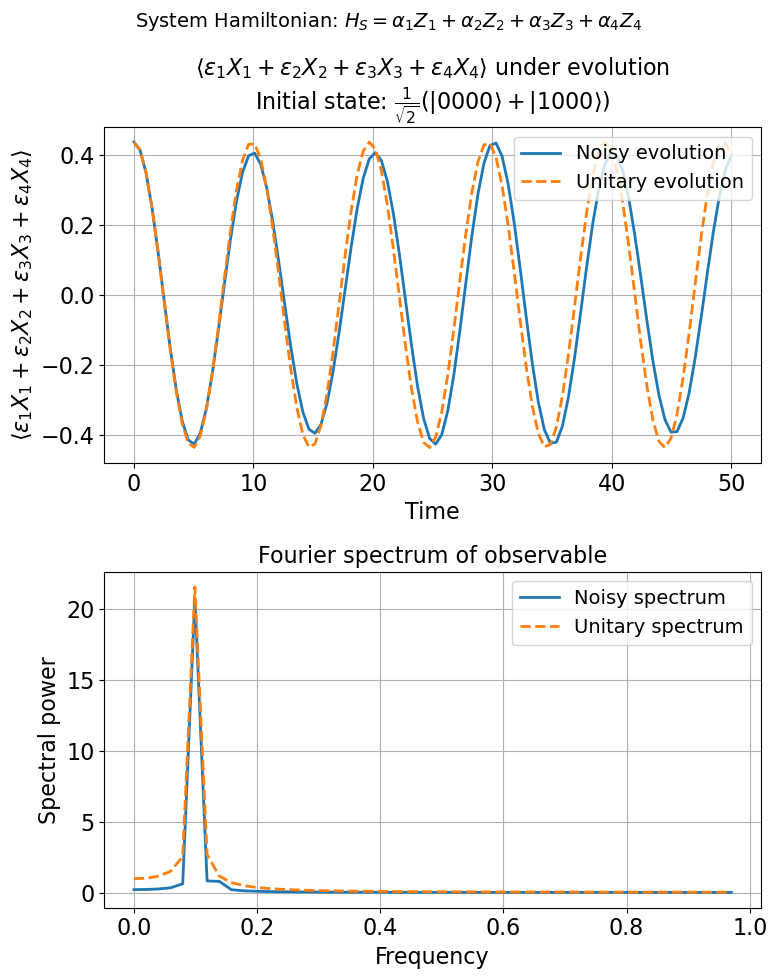

The dominant frequency from the Fourier transform is: 0.0990 (units of 1/time)


In [35]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import re
np.random.seed(42)

# Parameters - USER CAN CHANGE THESE
num_qubits = 4  # Change this to the desired number of qubits
g = 0.05
num_modes_per_bath = 1
N = 2  # Fock space truncation
kappa = 0.05
tlist = np.linspace(0, 50, 100)
save_base_path = rf"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\{num_qubits}QUBITS"
# Generate random coefficients for the Hamiltonian and observable
epsilon = np.random.uniform(0.1, 1.0, num_qubits)  # Coefficients for observable
alpha = np.random.uniform(0.1, 1.5, 2*num_qubits+1)  # Coefficients for system Hamiltonian


def build_op(op_qubit, pos):
    """Build an operator acting on position 'pos' in the full Hilbert space"""
    ops = [qeye(2) for _ in range(num_qubits)] + [qeye(N) for _ in range(num_qubits * num_modes_per_bath)]
    ops[pos] = op_qubit
    return tensor(ops)

# Create Pauli operators for all qubits
X_ops = [build_op(sigmax(), i) for i in range(num_qubits)]
Y_ops = [build_op(sigmay(), i) for i in range(num_qubits)]
Z_ops = [build_op(sigmaz(), i) for i in range(num_qubits)]

# Bath creation/annihilation operators
a_ops = []
for i in range(num_qubits * num_modes_per_bath):
    ops = [qeye(2) for _ in range(num_qubits)] + [destroy(N) if j == i else qeye(N) for j in range(num_qubits * num_modes_per_bath)]
    a_ops.append(tensor(ops))


# Observable operator acting only on the qubits' Hilbert space
X_ops_qubits = [tensor([sigmax() if j == i else qeye(2) for j in range(num_qubits)]) for i in range(num_qubits)]
observable_op = sum(epsilon[i] * X_ops_qubits[i] for i in range(num_qubits))


# System Hamiltonian: Nearest-neighbor XX and YY interactions
Hs_1 = 0
for i in range(num_qubits):
    Hs_1 += alpha[i]* Z_ops[i]


# Bath Hamiltonian
omega_list = np.random.uniform(0.5, 2.0, len(a_ops))  
Hb = sum(omega_list[i] * a_ops[i].dag() * a_ops[i] for i in range(len(a_ops)))

# System-bath coupling (pure dephasing)
Hsb = 0
for qubit in range(num_qubits):
    x = X_ops[qubit]
    for mode in range(num_modes_per_bath):
        a = a_ops[qubit * num_modes_per_bath + mode]
        Hsb += (g / np.sqrt(num_modes_per_bath)) * x * (a + a.dag())

# Total Hamiltonian
H_total_1 = Hs_1 + Hb + Hsb

# Initial state: all qubits in |0⟩ and all bath modes in vacuum
zero_state = tensor([basis(2, 0) for _ in range(num_qubits)] + [basis(N, 0) for _ in range(num_qubits * num_modes_per_bath)])
one_state =  tensor([basis(2,1)]+ [basis(2, 0) for _ in range(1,num_qubits)] + [basis(N, 0) for _ in range(num_qubits * num_modes_per_bath)])
psi = zero_state+one_state
psi = psi.unit()

# Collapse operators (for open system evolution)
c_ops = [np.sqrt(kappa) * a for a in a_ops]


H_total = H_total_1

# Evolution with noise (open system)
result_noisy = mesolve(H_total, psi, tlist, [])

# Evolution without noise (unitary)
result_unitary = sesolve(Hs_1, psi, tlist)


# Compute expectation values
observable_noisy = []
observable_unitary = []

for noisy_state, unitary_state in zip(result_noisy.states, result_unitary.states):
    # For unitary case: calculate expectation value directly
    rho_unitary = unitary_state.ptrace(list(range(num_qubits)))
    rho_unitary = rho_unitary / rho_unitary.tr()
    val_unitary = expect(observable_op, rho_unitary)
    observable_unitary.append(val_unitary)
    rho_noisy = noisy_state.ptrace(list(range(num_qubits)))
    rho_noisy = rho_noisy / rho_noisy.tr()
    val_noisy = expect(observable_op, rho_noisy)
    observable_noisy.append(val_noisy)

# Fourier Transform
energy_noisy_fft = np.abs(np.fft.fft(observable_noisy))
energy_unitary_fft = np.abs(np.fft.fft(observable_unitary))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Select only positive frequencies
pos_mask = freqs >= 0
freqs = freqs[pos_mask]
spectrum_noisy = energy_noisy_fft[pos_mask]
spectrum_unitary = energy_unitary_fft[pos_mask]

# Plotting
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))


# Create Hamiltonian title string

ham_title = r'System Hamiltonian: $H_S = '
for j in range(num_qubits):
    ham_title += fr'\alpha_{j+1} Z_{j+1}'
    if j < num_qubits - 1:
        ham_title += ' + '
ham_title += '$'
title = ham_title.replace(r'\alpha', 'alpha').replace(r'\ ', '_').replace(' ', '_').replace('$', '').replace('{', '').replace('}', '')
# Left: Observable
fig.suptitle(ham_title, fontsize=14, y=y)
if num_qubits == 1:
    obs_label = r'$\langle ' + fr'\epsilon_1 X_1 \rangle$'
else:
    obs_label = r'$\langle ' + ' + '.join([fr'\epsilon_{i+1} X_{i+1}' for i in range(num_qubits)]) + r'\rangle$'
axs[0].plot(tlist, observable_noisy, label='Noisy evolution', lw=2, color='tab:blue')
axs[0].plot(tlist, observable_unitary, '--', label='Unitary evolution', lw=2, color='tab:orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(obs_label)
axs[0].set_title(
    rf'{obs_label} under evolution' '\n'
    rf'Initial state: $\frac{{1}}{{\sqrt{{2}}}} \left( |{"0"*num_qubits}\rangle + |1{"0"*(num_qubits-1)}\rangle \right)$'
)
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
axs[1].plot(freqs, spectrum_noisy, label='Noisy spectrum', lw=2, color='tab:blue')
axs[1].plot(freqs, spectrum_unitary, '--', label='Unitary spectrum', lw=2, color='tab:orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].legend(loc='upper right')
axs[1].grid(True)

# Save and show
name = f"{num_qubits}_{title}_general_code.png"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()


# Print dominant frequency
idx_peak = np.argmax(spectrum_noisy)
freq_peak = freqs[idx_peak]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")

# Drude Lorentz Bath

## 1 QUBIT

### X_1

\begin{equation}
H_S = \alpha_1X_1
\end{equation}

10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00


30.1%. Run time:   0.07s. Est. time left: 00:00:00:00
40.1%. Run time:   0.09s. Est. time left: 00:00:00:00
50.1%. Run time:   0.12s. Est. time left: 00:00:00:00
60.1%. Run time:   0.14s. Est. time left: 00:00:00:00
70.1%. Run time:   0.15s. Est. time left: 00:00:00:00
80.2%. Run time:   0.17s. Est. time left: 00:00:00:00
90.2%. Run time:   0.19s. Est. time left: 00:00:00:00
100.0%. Run time:   0.20s. Est. time left: 00:00:00:00
Total run time:   0.20s


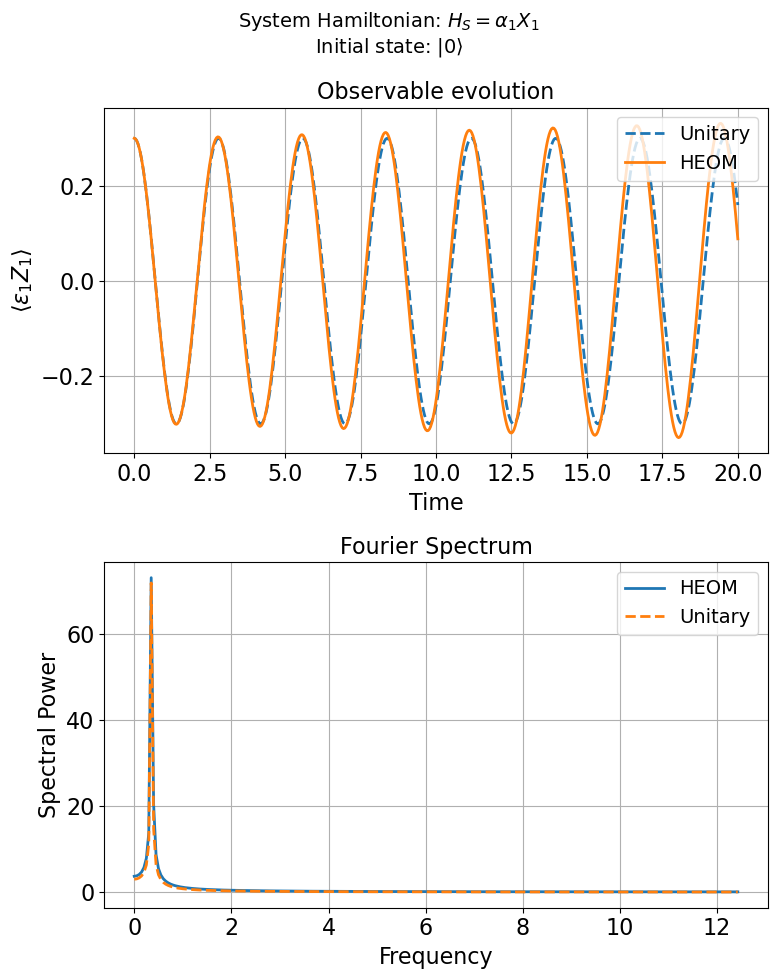

The dominant frequency from the Fourier transform is: 0.3493 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.3493 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import os
import re
np.random.seed(42)

# System operators (2-qubit Pauli)
X1 = sigmax()
Z1 = sigmaz()

#   Parameters
epsilon1=0.3
alpha_list = [0.6, 0.4, 0.6, 0.8, 1.0]
alpha_min = min(alpha_list)
lambda_d = 0.05 * alpha_min
gamma = 7 * alpha_min
max_depth=4
Nk=6
T = lambda_d

# System Hamiltonian
H_sys = alpha[0]*X1 

observable_op = epsilon1 * Z1 


# Drude-Lorentz baths for each qubit
baths = [
    DrudeLorentzBath(Z1, lambda_d, gamma, T, Nk),
]

# HEOM Liouvillian
HL = liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)

# Bell states
zero0 = basis(2,0)


psi = (zero0).unit()


# Simulation loop
tlist = np.linspace(0, 20, 500)

# HEOM evolution
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=Options(nsteps=10000))
rho0 = ket2dm(psi)
result = solver.run(rho0, tlist)
observable_vals = []
for state in result.states:
    # Partial trace to single qubits
    rho_0 = state.ptrace(0)

    # Normalize reduced single-qubit density matrices
    rho_0 = rho_0 / rho_0.tr()
    val = expect(observable_op, rho_0)
    # Append the expectation value to the list

    observable_vals.append(val)
fft_heom = np.abs(np.fft.fft(observable_vals))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
# Evolution without noise (unitary)
result_unitary = sesolve(H_sys, psi, tlist)
observable_vals_unitary = []
for state_unitary in result_unitary.states:
        rho_unitary = state_unitary.ptrace(0)
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_vals_unitary.append(val_unitary)        


# FFT for unitary evolution
pos_mask = freqs >= 0
fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
fft_unitary = fft_unitary[pos_mask]

# Plotting
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(
    r'System Hamiltonian: $H_S = \alpha_1 X_1$' + '\n' + r'Initial state: $|0\rangle$',
    fontsize=14,
    y=y,
    va='top'
)

axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)

axs[0].plot(tlist, observable_vals, label="HEOM", lw=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1\rangle$')
axs[0].set_title('Observable evolution')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs >= 0

freqs= freqs[pos_mask]
fft_heom = fft_heom[pos_mask]
axs[1].plot(freqs, fft_heom, label="HEOM", lw=2)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral Power')
axs[1].set_title('Fourier Spectrum')
axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
axs[1].legend(loc='upper right')
axs[1].grid(True)


name ="ket_0_x1"
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz/1Qubits" #To save the images
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, f"{name}_Drude_Lorentz.png")
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(fft_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary =freqs[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

### Z_1

\begin{equation}
H_s = Z_1
\end{equation}

10.0%. Run time:   0.04s. Est. time left: 00:00:00:00
20.0%. Run time:   0.08s. Est. time left: 00:00:00:00
30.1%. Run time:   0.13s. Est. time left: 00:00:00:00
40.1%. Run time:   0.17s. Est. time left: 00:00:00:00
50.1%. Run time:   0.22s. Est. time left: 00:00:00:00
60.1%. Run time:   0.27s. Est. time left: 00:00:00:00
70.1%. Run time:   0.30s. Est. time left: 00:00:00:00
80.2%. Run time:   0.33s. Est. time left: 00:00:00:00
90.2%. Run time:   0.36s. Est. time left: 00:00:00:00
100.0%. Run time:   0.39s. Est. time left: 00:00:00:00
Total run time:   0.39s


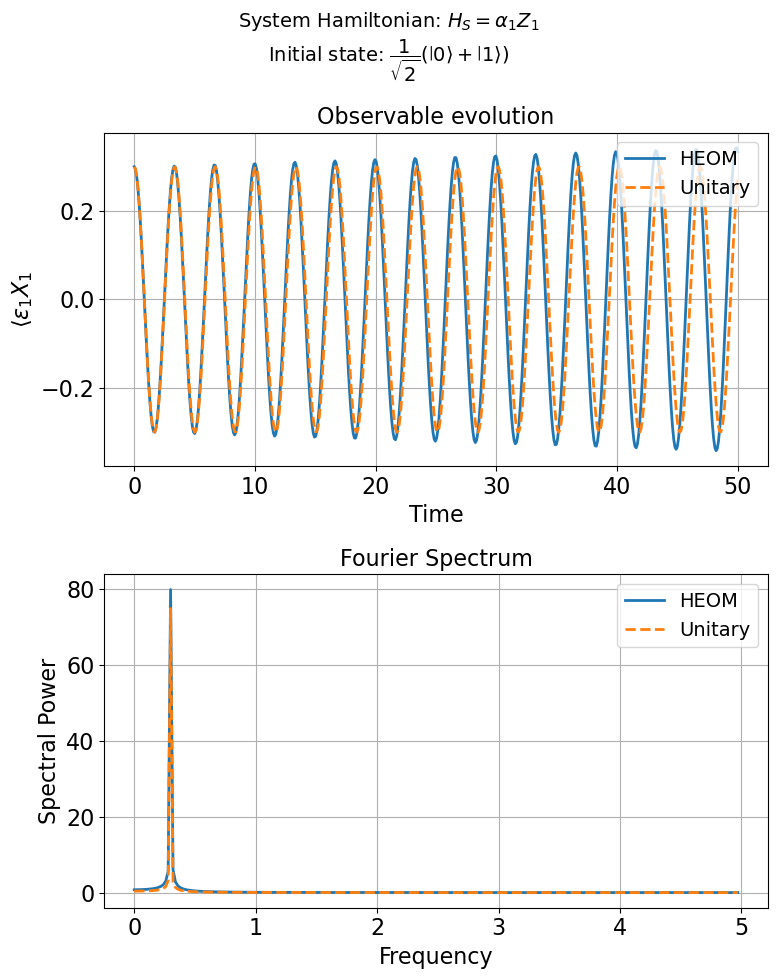

The dominant frequency from the Fourier transform is: 0.2994 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.2994 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [70]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import os
import re
np.random.seed(42)

# System operators (2-qubit Pauli)
X1 = sigmax()
Z1 = sigmaz()




#   Parameters
epsilon1=0.3
alpha_list = [0.6, 0.4, 0.6, 0.8, 1.0]
alpha_min = min(alpha_list)
lambda_d = 0.05 * alpha_min
gamma = 7 * alpha_min
max_depth=4
Nk=6
T = lambda_d

# System Hamiltonian
H_sys = alpha[1]*Z1 

observable_op = epsilon1 * X1 
# Drude-Lorentz baths for each qubit
baths = [
    DrudeLorentzBath(X1, lambda_d, gamma, T, Nk),
]

# HEOM Liouvillian
HL = liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)

# Bell states
zero0 = basis(2,0)
one0 = basis(2,1)

psi = (zero0+one0).unit()


# Simulation loop
tlist = np.linspace(0, 50, 500)

# HEOM evolution
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=Options(nsteps=10000))
rho0 = ket2dm(psi)
result = solver.run(rho0, tlist)
observable_vals = []
for state in result.states:
    # Partial trace to single qubits
    rho_0 = state.ptrace(0)

    # Normalize reduced single-qubit density matrices
    rho_0 = rho_0 / rho_0.tr()
    val = expect(observable_op, rho_0)
    observable_vals.append(val)

fft_heom = np.abs(np.fft.fft(observable_vals))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
# Evolution without noise (unitary)
result_unitary = sesolve(H_sys, psi, tlist)
observable_vals_unitary = []
for state_unitary in result_unitary.states:
        rho_unitary = state_unitary.ptrace(0)
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_vals_unitary.append(val_unitary)  

# FFT for unitary evolution
pos_mask = freqs >= 0
fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
fft_unitary = fft_unitary[pos_mask]
# Plotting
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(
    r'System Hamiltonian: $H_S = \alpha_1 Z_1$' + '\n' + r'Initial state: $ \dfrac{1}{\sqrt{2}} (\left |0\right \rangle +\left |1\right \rangle)$',
    fontsize=14,
    y=y,
    va='top'
)

axs[0].plot(tlist, observable_vals, label="HEOM", lw=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 X_1$')
axs[0].set_title('Observable evolution')
axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs >= 0

freqs= freqs[pos_mask]
fft_heom = fft_heom[pos_mask]
axs[1].plot(freqs, fft_heom, label="HEOM", lw=2)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral Power')
axs[1].set_title('Fourier Spectrum')

axs[1].grid(True)

axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
axs[1].legend(loc='upper right')
name ="ket_0_Z1"
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz/1Qubits" #To save the images
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, f"{name}_Drude_Lorentz.png")
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(fft_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary =freqs[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

## 2 Qubits

### X_1 + X_2

\begin{equation}
H_S = \alpha_1X_1 + \alpha_2X_2
\end{equation}

c:\Users\jalej\anaconda3\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


10.0%. Run time:   0.43s. Est. time left: 00:00:00:03
20.0%. Run time:   0.81s. Est. time left: 00:00:00:03
30.1%. Run time:   1.19s. Est. time left: 00:00:00:02
40.1%. Run time:   1.58s. Est. time left: 00:00:00:02
50.1%. Run time:   1.92s. Est. time left: 00:00:00:01
60.1%. Run time:   2.38s. Est. time left: 00:00:00:01
70.1%. Run time:   2.78s. Est. time left: 00:00:00:01
80.2%. Run time:   3.22s. Est. time left: 00:00:00:00
90.2%. Run time:   3.61s. Est. time left: 00:00:00:00
100.0%. Run time:   3.99s. Est. time left: 00:00:00:00
Total run time:   3.99s


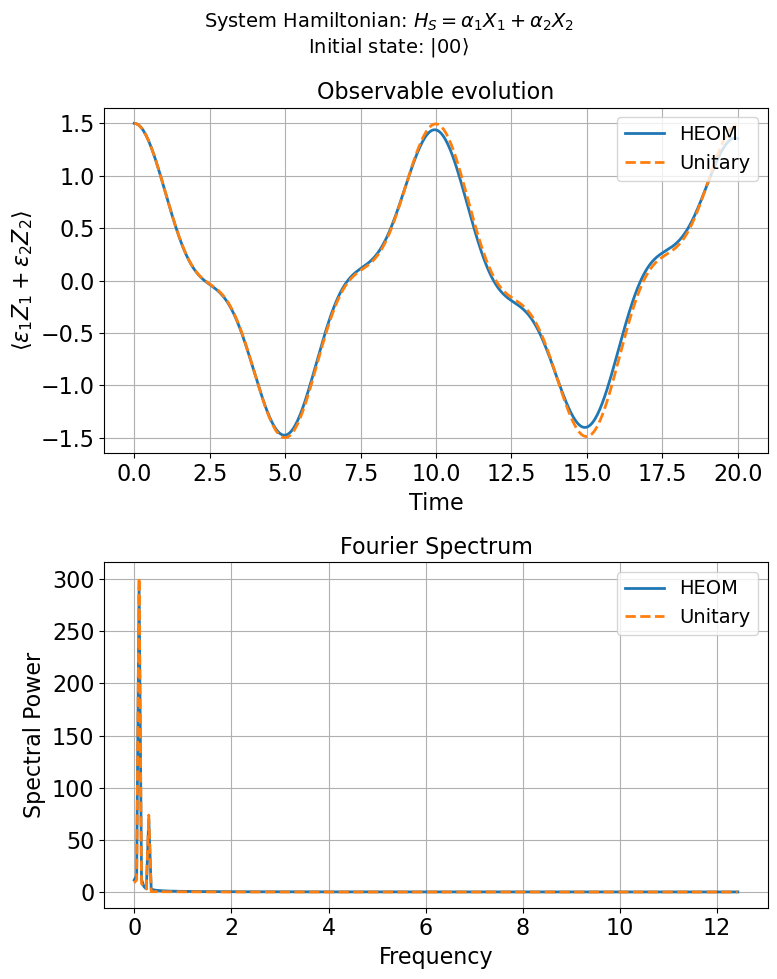

The dominant frequency from the Fourier transform is: 0.0998 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.0998 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import os
import re
np.random.seed(42)

# System operators (2-qubit Pauli)
X1 = tensor(sigmax(), qeye(2))
X2 = tensor(qeye(2), sigmax())
Z1 = tensor(sigmaz(), qeye(2))
Z2 = tensor(qeye(2), sigmaz())
# Parameters
epsilon1=0.3
epsilon2=1.2
alpha_list = [0.6, 0.4, 0.6, 0.8, 1.0]
alpha= np.array(alpha_list)

lambda_d = 0.05 * alpha
gamma = 7 * alpha
max_depth=4
Nk=6
T = lambda_d.min()
# System Hamiltonian
H_sys = alpha[1]*X1 + alpha[2]* X2

# Observable
observable_op = epsilon1 * Z1 + epsilon2 * Z2


# Drude-Lorentz baths for each qubit
baths = [
    DrudeLorentzBath(Z1, lambda_d[0], gamma[0], T, Nk),
    DrudeLorentzBath(Z2, lambda_d[1], gamma[1], T, Nk),
]

# HEOM Liouvillian
HL = liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)


zero0 = tensor(basis(2, 0), basis(2, 0))


psi = (zero0).unit()


# Simulation loop
tlist = np.linspace(0, 20, 500)  

# HEOM evolution
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=Options(nsteps=10000))
rho0 = ket2dm(psi)
result = solver.run(rho0, tlist)
observable_vals = []
for state in result.states:
    rho_0 = state.ptrace([0, 1])  # Partial trace to both qubits
    rho_0 = rho_0 / rho_0.tr()  # Normalize reduced density matrix
    val = expect(observable_op, rho_0)
    # Append the expectation value to the list
    observable_vals.append(val)
fft_heom = np.abs(np.fft.fft(observable_vals))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
# Evolution without noise (unitary)
result_unitary = sesolve(H_sys, psi, tlist)
observable_vals_unitary = []
for state_unitary in result_unitary.states:
        rho_unitary = state_unitary.ptrace([0, 1])
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_vals_unitary.append(val_unitary)  

# FFT for unitary evolution
pos_mask = freqs >= 0
fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
fft_unitary = fft_unitary[pos_mask]
# Plotting
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(
    r'System Hamiltonian: $H_S = \alpha_1 X_1 +\alpha_2 X_2$' + '\n' + r'Initial state: $|00\rangle$',
    fontsize=14,
    y=y,
    va='top'
)

axs[0].plot(tlist, observable_vals, label="HEOM", lw=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 \rangle$')
axs[0].set_title('Observable evolution')
axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs >= 0

freqs= freqs[pos_mask]
fft_heom = fft_heom[pos_mask]
axs[1].plot(freqs, fft_heom, label="HEOM", lw=2)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral Power')
axs[1].set_title('Fourier Spectrum')

axs[1].grid(True)

axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
axs[1].legend(loc='upper right')

name ="ket_00_X1_X2"
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz/2Qubits" #To save the images
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, f"{name}_Drude_Lorentz.png")
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(fft_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary =freqs[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

### X_1X_2+Y_1Y_2

\begin{equation}
H_S = \alpha_1 X_1X_2+ \alpha_2 Y_1Y_2
\end{equation}

10.0%. Run time:   0.72s. Est. time left: 00:00:00:06
20.0%. Run time:   1.32s. Est. time left: 00:00:00:05
30.1%. Run time:   1.91s. Est. time left: 00:00:00:04
40.1%. Run time:   2.55s. Est. time left: 00:00:00:03
50.1%. Run time:   3.25s. Est. time left: 00:00:00:03
60.1%. Run time:   3.95s. Est. time left: 00:00:00:02
70.1%. Run time:   4.65s. Est. time left: 00:00:00:01
80.2%. Run time:   5.19s. Est. time left: 00:00:00:01
90.2%. Run time:   5.70s. Est. time left: 00:00:00:00
100.0%. Run time:   6.25s. Est. time left: 00:00:00:00
Total run time:   6.25s


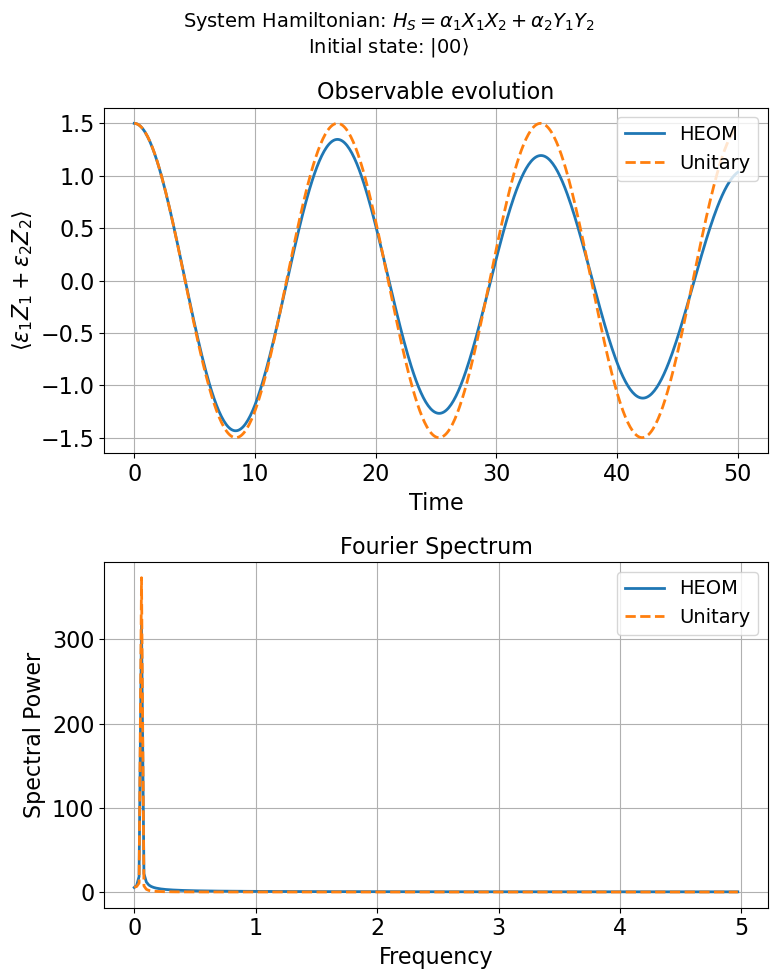

The dominant frequency from the Fourier transform is: 0.0599 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.0599 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import os
import re
np.random.seed(42)

# System operators (2-qubit Pauli)
X1 = tensor(sigmax(), qeye(2))
X2 = tensor(qeye(2), sigmax())
Y1 = tensor(sigmay(), qeye(2))
Y2 = tensor(qeye(2), sigmay())
Z1 = tensor(sigmaz(), qeye(2))
Z2 = tensor(qeye(2), sigmaz())



# Parameters
epsilon1=0.3
epsilon2=1.2
alpha_list = [0.6, 0.4, 0.6, 0.8, 1.0]
alpha = np.array(alpha_list)

lambda_d = 0.05 * alpha
gamma = 7 * alpha
max_depth=4
Nk=6
T = lambda_d.min()
# System Hamiltonian
H_sys = alpha[0]*X1*X2 + alpha[1]* Y1*Y2

# Observable
observable_op = epsilon1 * Z1 + epsilon2 * Z2
# Drude-Lorentz baths for each qubit
baths = [
    DrudeLorentzBath(Z1, lambda_d[0], gamma[0], T, Nk),
    DrudeLorentzBath(Z2, lambda_d[1], gamma[1], T, Nk),
]

# HEOM Liouvillian
HL = liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)


zero0 = tensor(basis(2, 0), basis(2, 0))


psi = (zero0).unit()


# Simulation loop
tlist = np.linspace(0, 50, 500)  

# HEOM evolution
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=Options(nsteps=10000))
rho0 = ket2dm(psi)
result = solver.run(rho0, tlist)
observable_vals = []
for state in result.states:
    rho_0 = state.ptrace([0, 1])  #Partial trace to both qubits
    rho_0 = rho_0 / rho_0.tr()  # Normalize reduced density matrix
    val = expect(observable_op, rho_0)
    # Append the expectation value to the list

    observable_vals.append(val)
fft_heom = np.abs(np.fft.fft(observable_vals))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
# Evolution without noise (unitary)
result_unitary = sesolve(H_sys, psi, tlist)
observable_vals_unitary = []
for state_unitary in result_unitary.states:
        rho_unitary = state_unitary.ptrace([0, 1])
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_vals_unitary.append(val_unitary)  

# FFT for unitary evolution
pos_mask = freqs >= 0
fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
fft_unitary = fft_unitary[pos_mask]
# Plotting

if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(
    r'System Hamiltonian: $H_S = \alpha_1 X_1X_2 +\alpha_2 Y_1Y_2$' + '\n' + r'Initial state: $|00\rangle$',
    fontsize=14,
    y=y,
    va='top'
)

axs[0].plot(tlist, observable_vals, label="HEOM", lw=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 \rangle$')
axs[0].set_title('Observable evolution')
axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)

axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs >= 0

freqs= freqs[pos_mask]
fft_heom = fft_heom[pos_mask]
axs[1].plot(freqs, fft_heom, label="HEOM", lw=2)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral Power')
axs[1].set_title('Fourier Spectrum')

axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
axs[1].legend(loc='upper right')
axs[1].grid(True)

name ="ket_00_X1X2_Y1Y2"
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz/2Qubits" #To save the images
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, f"{name}_Drude_Lorentz.png")
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(fft_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary =freqs[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

### Z_1 + Z_2

\begin{equation}
 H_s = \alpha_1 Z_1 + \alpha_2 Z_2
\end{equation}

10.0%. Run time:   0.47s. Est. time left: 00:00:00:04
20.0%. Run time:   0.98s. Est. time left: 00:00:00:03
30.1%. Run time:   1.42s. Est. time left: 00:00:00:03
40.1%. Run time:   1.83s. Est. time left: 00:00:00:02
50.1%. Run time:   2.30s. Est. time left: 00:00:00:02
60.1%. Run time:   2.73s. Est. time left: 00:00:00:01
70.1%. Run time:   3.13s. Est. time left: 00:00:00:01
80.2%. Run time:   3.54s. Est. time left: 00:00:00:00
90.2%. Run time:   3.93s. Est. time left: 00:00:00:00
100.0%. Run time:   4.34s. Est. time left: 00:00:00:00
Total run time:   4.34s


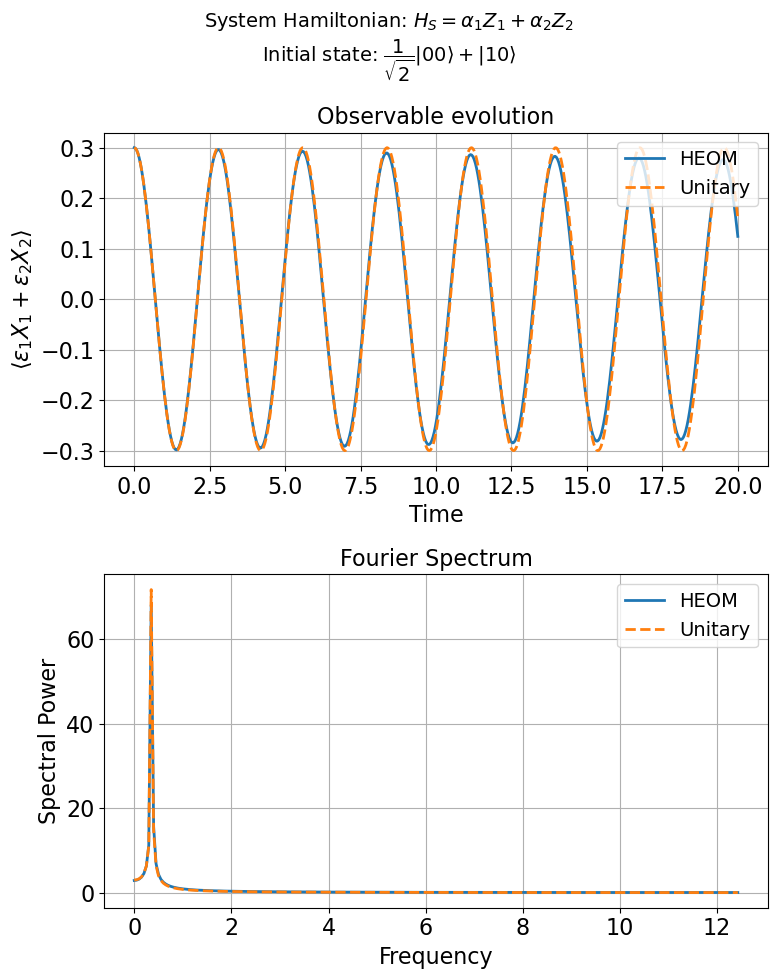

The dominant frequency from the Fourier transform is: 0.3493 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.3493 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import os
import re
np.random.seed(42)

# System operators (2-qubit Pauli)
X1 = tensor(sigmax(), qeye(2))
X2 = tensor(qeye(2), sigmax())
Z1 = tensor(sigmaz(), qeye(2))
Z2 = tensor(qeye(2), sigmaz())

# Parameters
epsilon1=0.3
epsilon2=1.2
alpha_list = [0.6, 0.4, 0.6, 0.8, 1.0]
alpha = np.array(alpha_list)

lambda_d = 0.05 * alpha
gamma = 7 * alpha
max_depth=4
Nk=6
T = lambda_d.min()

# System Hamiltonian
H_sys = alpha[0]*Z1 + alpha[1]* Z2

# Observable
observable_op = epsilon1 * X1 + epsilon2 * X2


# Drude-Lorentz baths for each qubit
baths = [
    DrudeLorentzBath(X1, lambda_d[0], gamma[0], T, Nk),
    DrudeLorentzBath(X2, lambda_d[1], gamma[1], T, Nk),
]

# HEOM Liouvillian
HL = liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)


zero0 = tensor(basis(2, 0), basis(2, 0))
one0 = tensor(basis(2, 1), basis(2, 0))

psi = (zero0+one0).unit()


# Simulation loop
tlist = np.linspace(0, 20, 500)  

# HEOM evolution
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=Options(nsteps=10000))
rho0 = ket2dm(psi)
result = solver.run(rho0, tlist)
observable_vals = []
for state in result.states:
    val = expect(observable_op, state.ptrace([0, 1]))
    observable_vals.append(val)
fft_heom = np.abs(np.fft.fft(observable_vals))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
result_unitary = sesolve(H_sys, psi, tlist)
observable_vals_unitary = []
for state_unitary in result_unitary.states:
        rho_unitary = state_unitary.ptrace([0, 1])
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_vals_unitary.append(val_unitary)  

# FFT for unitary evolution
pos_mask = freqs >= 0
fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
fft_unitary = fft_unitary[pos_mask]
# Plotting
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(
    r'System Hamiltonian: $H_S = \alpha_1 Z_1 +\alpha_2 Z_2$' + '\n' + r'Initial state: $ \dfrac{1}{\sqrt{2}}|00\rangle + |10\rangle $',
    fontsize=14,
    y=y,
    va='top'
)

axs[0].plot(tlist, observable_vals, label="HEOM", lw=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 X_1 + \epsilon_2 X_2 \rangle$')
axs[0].set_title('Observable evolution')
axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)

axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs >= 0

freqs= freqs[pos_mask]
fft_heom = fft_heom[pos_mask]
axs[1].plot(freqs, fft_heom, label="HEOM", lw=2)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral Power')
axs[1].set_title('Fourier Spectrum')

axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
axs[1].legend(loc='upper right')
axs[1].grid(True)


name ="Z1_Z2"
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz/2Qubits" #To save the images
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, f"{name}_Drude_Lorentz.png")
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(fft_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary =freqs[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

## 3 QUBITS

### X1+X2+X3

\begin{equation}
H_S = \alpha_1X_1+ \alpha_2X_2 + \alpha_3X_3
\end{equation}

10.0%. Run time:  19.11s. Est. time left: 00:00:02:51
20.0%. Run time:  37.70s. Est. time left: 00:00:02:30
30.1%. Run time:  56.17s. Est. time left: 00:00:02:10
40.1%. Run time:  74.67s. Est. time left: 00:00:01:51
50.1%. Run time:  93.17s. Est. time left: 00:00:01:32
60.1%. Run time: 111.70s. Est. time left: 00:00:01:14
70.1%. Run time: 130.28s. Est. time left: 00:00:00:55
80.2%. Run time: 149.34s. Est. time left: 00:00:00:36
90.2%. Run time: 170.72s. Est. time left: 00:00:00:18
100.0%. Run time: 190.93s. Est. time left: 00:00:00:00
Total run time: 190.94s


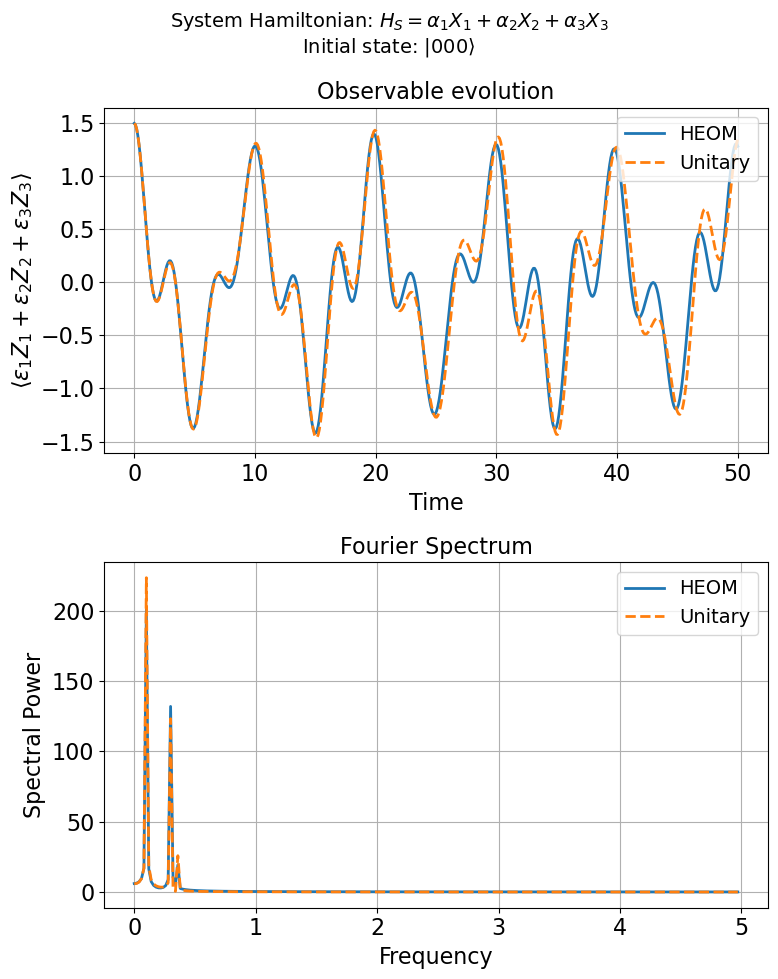

The dominant frequency from the Fourier transform is: 0.0998 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.0998 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import os
import re
np.random.seed(42)

# System operators (2-qubit Pauli)
X1 = tensor(sigmax(), qeye(2), qeye(2))
X2 = tensor(qeye(2), sigmax(), qeye(2))
X3 = tensor(qeye(2), qeye(2), sigmax())

Y1 = tensor(sigmay(), qeye(2), qeye(2))
Y2 = tensor(qeye(2), sigmay(), qeye(2))
Y3 = tensor(qeye(2), qeye(2), sigmay())
Z1 = tensor(sigmaz(), qeye(2), qeye(2))
Z2 = tensor(qeye(2), sigmaz(), qeye(2))
Z3 = tensor(qeye(2), qeye(2), sigmaz())



# Parameters
epsilon1= 0.1
epsilon2= 0.5
epsilon3= 0.9
alpha_list = [0.6, 0.4, 0.6, 0.8, 1.0]
alpha = np.array(alpha_list)

lambda_d = 0.05 * alpha
gamma = 7 * alpha
max_depth=4
Nk=6
T = lambda_d.min()

# System Hamiltonian
H_sys = alpha[0]*X1 + alpha[1]* X2 + alpha[2] * X3

# Observable
observable_op = epsilon1 * Z1 + epsilon2 * Z2 + epsilon3 * Z3


# Drude-Lorentz baths for each qubit
baths = [
    DrudeLorentzBath(Z1, lambda_d[0], gamma[0], T, Nk),
    DrudeLorentzBath(Z2, lambda_d[1], gamma[1], T, Nk),
    DrudeLorentzBath(Z3, lambda_d[2], gamma[2], T, Nk),
]

# HEOM Liouvillian
HL = liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)


zero0 = tensor(basis(2, 0), basis(2, 0),basis(2, 0))


psi = (zero0).unit()


# Simulation loop
tlist = np.linspace(0, 20, 100)  

# HEOM evolution
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=Options(nsteps=10000))
rho0 = ket2dm(psi)
result = solver.run(rho0, tlist)
observable_vals = []
for state in result.states:
    rho_0 = state.ptrace([0, 1, 2]) 
    rho_0 = rho_0 / rho_0.tr()  # Normalize reduced density matrix
    val = expect(observable_op, rho_0)
    # Append the expectation value to the list
    observable_vals.append(val)
fft_heom = np.abs(np.fft.fft(observable_vals))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
result_unitary = sesolve(H_sys, psi, tlist)
observable_vals_unitary = []
for state_unitary in result_unitary.states:
        rho_unitary = state_unitary.ptrace([0, 1,2])
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_vals_unitary.append(val_unitary)  

# FFT for unitary evolution
pos_mask = freqs >= 0
fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
fft_unitary = fft_unitary[pos_mask]
# Plotting
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(
    r'System Hamiltonian: $H_S = \alpha_1 X_1 +\alpha_2 X_2 + \alpha_3 X_3$' + '\n' + r'Initial state: $|000\rangle$',
    fontsize=14,
    y=y,
    va='top'
)

axs[0].plot(tlist, observable_vals, label="HEOM", lw=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 +\epsilon_3 Z_3 \rangle$')
axs[0].set_title('Observable evolution')
axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs >= 0

freqs= freqs[pos_mask]
fft_heom = fft_heom[pos_mask]
axs[1].plot(freqs, fft_heom, label="HEOM", lw=2)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral Power')
axs[1].set_title('Fourier Spectrum')
axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
axs[1].legend(loc='upper right')
axs[1].grid(True)

name ="ket_00_X1_X2_X3"
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz/3Qubits" #To save the images
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, f"{name}_Drude_Lorentz.png")
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(fft_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary =freqs[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

### X_1 * X_2 + Y_1 * Y_2 + X_2 * X_3 + Y_2 * Y_3

\begin{equation}
H_s= \alpha_1 X_1 * X_2 + \alpha_2Y_1 * Y_2 + \alpha_3X_2 * X_3 + \alpha_4Y_2 * Y_3
\end{equation}

10.1%. Run time:   6.01s. Est. time left: 00:00:00:53
20.2%. Run time:  12.41s. Est. time left: 00:00:00:49
30.3%. Run time:  17.92s. Est. time left: 00:00:00:41
40.4%. Run time:  23.32s. Est. time left: 00:00:00:34
50.5%. Run time:  29.17s. Est. time left: 00:00:00:28
60.6%. Run time:  35.09s. Est. time left: 00:00:00:22
70.7%. Run time:  40.45s. Est. time left: 00:00:00:16
80.8%. Run time:  46.65s. Est. time left: 00:00:00:11
90.9%. Run time:  52.94s. Est. time left: 00:00:00:05
100.0%. Run time:  58.05s. Est. time left: 00:00:00:00
Total run time:  58.05s


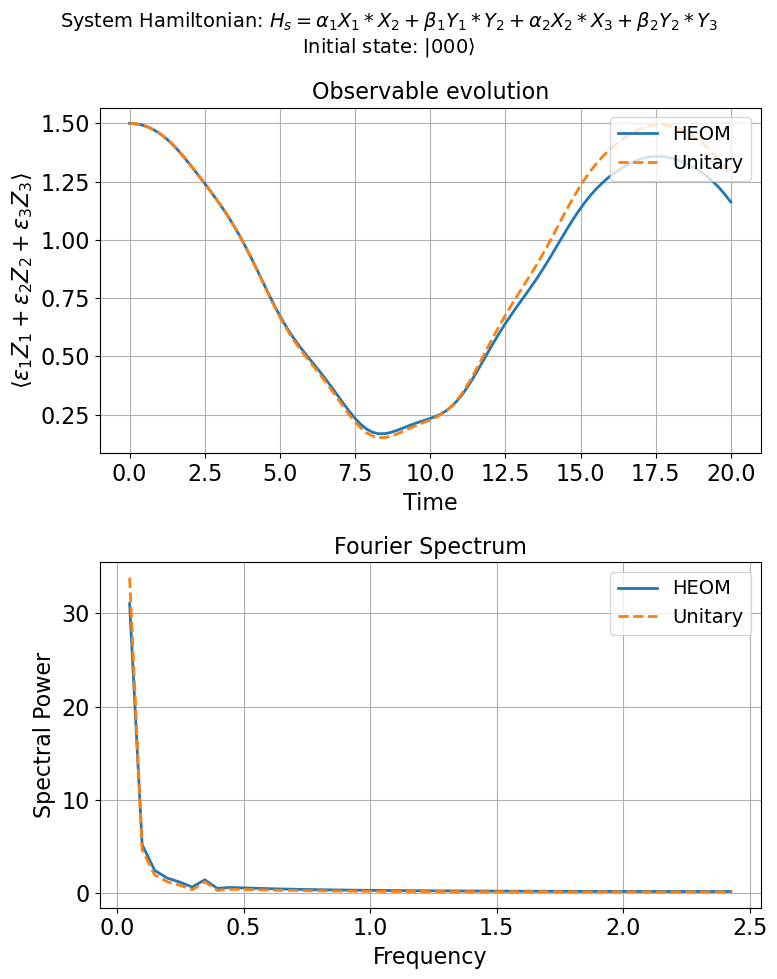

The dominant frequency from the Fourier transform is: 0.0495 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.0495 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import os
import re
np.random.seed(42)

# System operators (2-qubit Pauli)
X1 = tensor(sigmax(), qeye(2), qeye(2))
X2 = tensor(qeye(2), sigmax(), qeye(2))
X3 = tensor(qeye(2), qeye(2), sigmax())

Y1 = tensor(sigmay(), qeye(2), qeye(2))
Y2 = tensor(qeye(2), sigmay(), qeye(2))
Y3 = tensor(qeye(2), qeye(2), sigmay())
Z1 = tensor(sigmaz(), qeye(2), qeye(2))
Z2 = tensor(qeye(2), sigmaz(), qeye(2))
Z3 = tensor(qeye(2), qeye(2), sigmaz())


# Parameters
epsilon1= 0.1
epsilon2= 0.5
epsilon3= 0.9
alpha_list = [0.6, 0.4, 0.6, 0.8, 1.0,1.1,0.7,0.8]
alpha = np.array(alpha_list)

lambda_d = 0.05 * alpha
gamma = 7 * alpha
max_depth=4
Nk=6
T = lambda_d.min()
# System Hamiltonian
H_sys = alpha[0]*X1*X2 + alpha[1]* Y1*Y2 + alpha[2]* X2*X3 + alpha[3] * Y2*Y3

# Observable
observable_op = epsilon1 * Z1 + epsilon2 * Z2 + epsilon3 * Z3


# Drude-Lorentz baths for each qubit
baths = [
    DrudeLorentzBath(Z1, lambda_d[0], gamma[0], T, Nk),
    DrudeLorentzBath(Z2, lambda_d[1], gamma[1], T, Nk),
    DrudeLorentzBath(Z3, lambda_d[2], gamma[2], T, Nk),
]

# HEOM Liouvillian
HL = liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)


zero0 = tensor(basis(2, 0), basis(2, 0),basis(2, 0))


psi = (zero0).unit()


# Simulation loop
tlist = np.linspace(0, 20, 100)  

# HEOM evolution
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=Options(nsteps=10000))
rho0 = ket2dm(psi)
result = solver.run(rho0, tlist)
observable_vals = []
for state in result.states:
    rho_0 = state.ptrace([0, 1, 2])
    rho_0 = rho_0 / rho_0.tr()  # Normalize reduced density matrix
    val = expect(observable_op, rho_0)
    # Append the expectation value to the list
    observable_vals.append(val)
fft_heom = np.abs(np.fft.fft(observable_vals))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
result_unitary = sesolve(H_sys, psi, tlist)
observable_vals_unitary = []
for state_unitary in result_unitary.states:
        rho_unitary = state_unitary.ptrace([0, 1,2])
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_vals_unitary.append(val_unitary)  

# FFT for unitary evolution
pos_mask = freqs > 0
fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
fft_unitary = fft_unitary[pos_mask]
# Plotting
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(
    r'System Hamiltonian: $H_s= \alpha_1 X_1 * X_2 + \beta_1 Y_1 * Y_2 +  \alpha_2 X_2 * X_3 +  \beta_2 Y_2 * Y_3 $' + '\n' + r'Initial state: $|000\rangle$',
    fontsize=14,
    y=y,
    va='top'
)

axs[0].plot(tlist, observable_vals, label="HEOM", lw=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 + \epsilon_3 Z_3 \rangle$')
axs[0].set_title('Observable evolution')
axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)

axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs > 0

freqs= freqs[pos_mask]
fft_heom = fft_heom[pos_mask]
axs[1].plot(freqs, fft_heom, label="HEOM", lw=2)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral Power')
axs[1].set_title('Fourier Spectrum')

axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
axs[1].legend(loc='upper right')
axs[1].grid(True)

name ="ket_00_X1X2_Y1Y2_X2X3_Y2Y3"
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz/3Qubits" #To save the images
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, f"{name}_Drude_Lorentz.png")
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(fft_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary =freqs[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

### Z1+Z2+Z3

\begin{equation}
H_S = \alpha_1Z_1+ \alpha_2Z_2 + \alpha_3Z_3
\end{equation}

10.1%. Run time:   8.20s. Est. time left: 00:00:01:12
20.2%. Run time:  18.32s. Est. time left: 00:00:01:12
30.3%. Run time:  28.17s. Est. time left: 00:00:01:04
40.4%. Run time:  37.84s. Est. time left: 00:00:00:55
50.5%. Run time:  47.73s. Est. time left: 00:00:00:46
60.6%. Run time:  57.02s. Est. time left: 00:00:00:37
70.7%. Run time:  67.09s. Est. time left: 00:00:00:27
80.8%. Run time:  77.08s. Est. time left: 00:00:00:18
90.9%. Run time:  85.88s. Est. time left: 00:00:00:08
100.0%. Run time:  94.88s. Est. time left: 00:00:00:00
Total run time:  94.89s


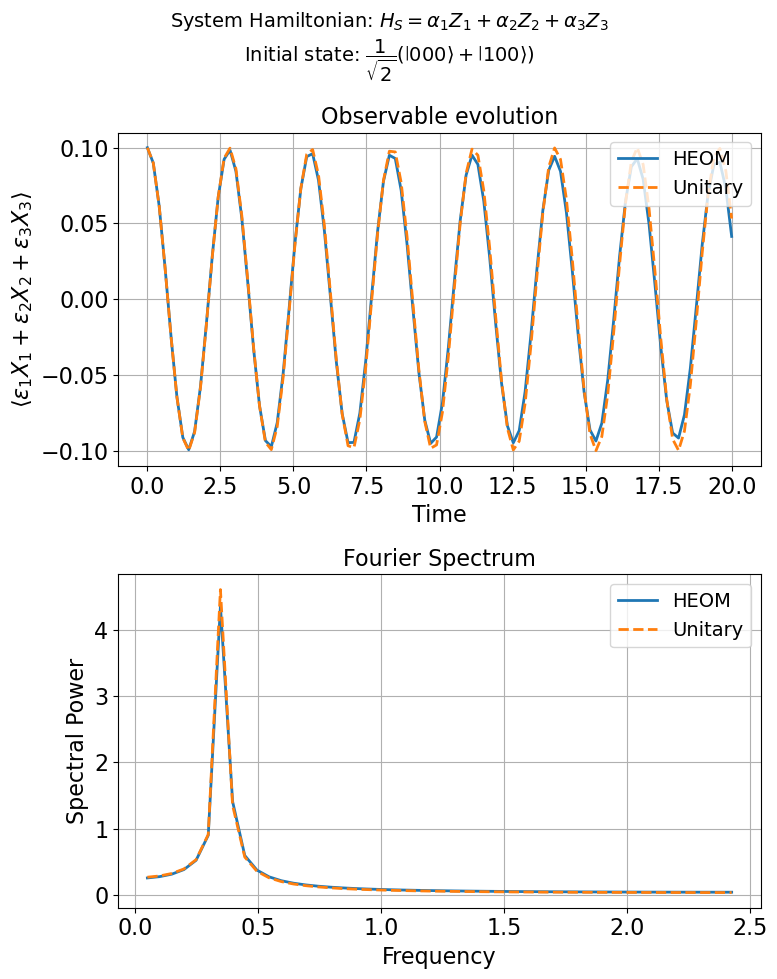

The dominant frequency from the Fourier transform is: 0.3465 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.3465 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import os
import re
np.random.seed(42)

# System operators (2-qubit Pauli)
X1 = tensor(sigmax(), qeye(2), qeye(2))
X2 = tensor(qeye(2), sigmax(), qeye(2))
X3 = tensor(qeye(2), qeye(2), sigmax())

Y1 = tensor(sigmay(), qeye(2), qeye(2))
Y2 = tensor(qeye(2), sigmay(), qeye(2))
Y3 = tensor(qeye(2), qeye(2), sigmay())
Z1 = tensor(sigmaz(), qeye(2), qeye(2))
Z2 = tensor(qeye(2), sigmaz(), qeye(2))
Z3 = tensor(qeye(2), qeye(2), sigmaz())


# Parameters
epsilon1= 0.1
epsilon2= 0.5
epsilon3= 0.9
alpha_list = [0.6, 0.4, 0.6, 0.8, 1.0,1.1,0.7,0.8]
alpha = np.array(alpha_list)

lambda_d = 0.05 * alpha
gamma = 7 * alpha
max_depth=4
Nk=6
T = lambda_d.min()
# System Hamiltonian
H_sys = alpha[0]*Z1 + alpha[1]* Z2 + alpha[2] * Z3

# Observable
observable_op = epsilon1 * X1 + epsilon2 * X2 + epsilon3 * X3



# Drude-Lorentz baths for each qubit
baths = [
    DrudeLorentzBath(X1, lambda_d[0], gamma[0], T, Nk),
    DrudeLorentzBath(X2, lambda_d[1], gamma[1], T, Nk),
    DrudeLorentzBath(X3, lambda_d[2], gamma[2], T, Nk),
]

# HEOM Liouvillian
HL = liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)


zero0 = tensor(basis(2, 0), basis(2, 0),basis(2, 0))
one0 = tensor(basis(2, 1), basis(2, 0),basis(2, 0))

psi = (zero0+one0).unit()


# Simulation loop
tlist = np.linspace(0, 20, 100)  

# HEOM evolution
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=Options(nsteps=10000))
rho0 = ket2dm(psi)
result = solver.run(rho0, tlist)
observable_vals = []
for state in result.states:
    rho= state.ptrace([0, 1, 2])  # Full state for all qubits
    val = expect(observable_op, rho)  # Expectation value of the observable
    observable_vals.append(val)
fft_heom = np.abs(np.fft.fft(observable_vals))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
result_unitary = sesolve(H_sys, psi, tlist)
observable_vals_unitary = []
for state_unitary in result_unitary.states:
        rho_unitary = state_unitary.ptrace([0, 1,2])
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_vals_unitary.append(val_unitary)  

# FFT for unitary evolution
pos_mask = freqs > 0
fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
fft_unitary = fft_unitary[pos_mask]
# Plotting
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(
    r'System Hamiltonian: $H_S = \alpha_1 Z_1 +\alpha_2 Z_2 + \alpha_3 Z_3$' + '\n' + r'Initial state: $  \dfrac {1}{\sqrt{2}} (\left |000\right \rangle+\left |100\right \rangle) $',
    fontsize=14,
    y=y,
    va='top'
)

axs[0].plot(tlist, observable_vals, label="HEOM", lw=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 X_1 + \epsilon_2 X_2 +\epsilon_3 X_3 \rangle$')
axs[0].set_title('Observable evolution')
axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)

axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs > 0

freqs= freqs[pos_mask]
fft_heom = fft_heom[pos_mask]
axs[1].plot(freqs, fft_heom, label="HEOM", lw=2)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral Power')
axs[1].set_title('Fourier Spectrum')

axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
axs[1].legend(loc='upper right')
axs[1].grid(True)


name ="_Z1_Z2_Z3"
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz/3Qubits" #To save the images
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, f"{name}_Drude_Lorentz.png")
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(fft_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary =freqs[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

## 4 QUBITS



### $\alpha_1 X_1 + \alpha_2 X_2 + \alpha_3 X_3 + \alpha_4 X_4$

\begin{equation}
H_S = \alpha_1 X_1 + \alpha_2 X_2 + \alpha_3 X_3 + \alpha_4 X_4
\end{equation}

c:\Users\jalej\anaconda3\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


10.0%. Run time:   5.66s. Est. time left: 00:00:00:50
20.0%. Run time:  10.53s. Est. time left: 00:00:00:42
30.1%. Run time:  15.55s. Est. time left: 00:00:00:36
40.1%. Run time:  20.45s. Est. time left: 00:00:00:30
50.1%. Run time:  25.32s. Est. time left: 00:00:00:25
60.1%. Run time:  30.23s. Est. time left: 00:00:00:20
70.1%. Run time:  35.04s. Est. time left: 00:00:00:14
80.2%. Run time:  39.81s. Est. time left: 00:00:00:09
90.2%. Run time:  44.64s. Est. time left: 00:00:00:04
100.0%. Run time:  49.39s. Est. time left: 00:00:00:00
Total run time:  49.40s


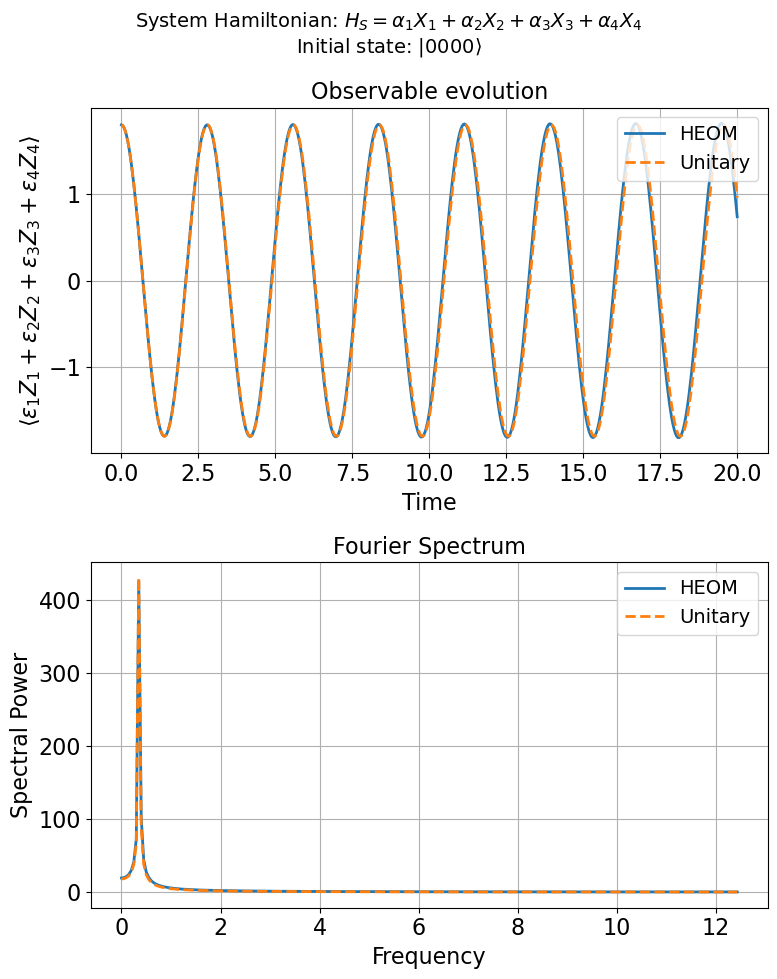

The dominant frequency from the Fourier transform is: 0.3493 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.3493 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import os
import re
np.random.seed(42)

# System operators (2-qubit Pauli)
X1 = tensor(sigmax(), qeye(2), qeye(2), qeye(2))
X2 = tensor(qeye(2), sigmax(), qeye(2), qeye(2))
X3 = tensor(qeye(2), qeye(2), sigmax(), qeye(2))
X4 = tensor(qeye(2), qeye(2), qeye(2), sigmax())
Y1 = tensor(sigmay(), qeye(2), qeye(2), qeye(2))
Y2 = tensor(qeye(2), sigmay(), qeye(2), qeye(2))
Y3 = tensor(qeye(2), qeye(2), sigmay(), qeye(2))
Y4 = tensor(qeye(2), qeye(2), qeye(2), sigmay())
Z1 = tensor(sigmaz(), qeye(2), qeye(2), qeye(2))
Z2 = tensor(qeye(2), sigmaz(), qeye(2), qeye(2))
Z3 = tensor(qeye(2), qeye(2), sigmaz(), qeye(2))
Z4 = tensor(qeye(2), qeye(2), qeye(2), sigmaz())

# Parameters
epsilon1= 0.1
epsilon2= 0.5
epsilon3= 0.9
epsilon4= 0.3
alpha_list = [0.6, 0.4, 0.6, 0.8, 1.0,1.1,0.7,0.8]
alpha = np.array(alpha_list)

lambda_d = 0.05 * alpha
gamma = 7 * alpha
max_depth=3
Nk=3
T = lambda_d.min()
# System Hamiltonian
H_sys = alpha[0]*Z1 + alpha[1]* Z2 + alpha[2] * Z3


# System Hamiltonian
H_sys = alpha[0]*X1 + alpha[0]* X2 + alpha[0] * X3+ alpha[0] *X4

# Observable
observable_op = epsilon1 * Z1 + epsilon2 * Z2 + epsilon3 * Z3 + epsilon4 * Z4



# Drude-Lorentz baths for each qubit
baths = [
    DrudeLorentzBath(Z1, lambda_d[0], gamma[0], T, Nk),
    DrudeLorentzBath(Z2, lambda_d[1], gamma[1], T, Nk),
    DrudeLorentzBath(Z3, lambda_d[2], gamma[2], T, Nk),
    DrudeLorentzBath(Z4, lambda_d[3], gamma[3], T, Nk),
]

# HEOM Liouvillian
HL = liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)


zero0 = tensor(basis(2, 0), basis(2, 0),basis(2, 0), basis(2, 0))


psi = (zero0).unit()


# Simulation loop
tlist = np.linspace(0, 20, 500)  

# HEOM evolution
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=Options(nsteps=10000))
rho0 = ket2dm(psi)
result = solver.run(rho0, tlist)
observable_vals = []
for state in result.states:
    rho = state.ptrace([0, 1, 2, 3])  # Full state for all qubits
    val = expect(observable_op, rho)  # Expectation value of the observable
    # Append the expectation value to the list
    observable_vals.append(val)
fft_heom = np.abs(np.fft.fft(observable_vals))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
result_unitary = sesolve(H_sys, psi, tlist)
observable_vals_unitary = []
for state_unitary in result_unitary.states:
        rho_unitary = state_unitary.ptrace([0, 1,2,3])
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_vals_unitary.append(val_unitary)  

# FFT for unitary evolution
pos_mask = freqs >= 0
fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
fft_unitary = fft_unitary[pos_mask]
# Plotting
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(
    r'System Hamiltonian: $H_S = \alpha_1 X_1 +\alpha_2 X_2 + \alpha_3 X_3+\alpha_4 X_4 $' + '\n' + r'Initial state: $|0000\rangle$',
    fontsize=14,
    y=y,
    va='top'
)

axs[0].plot(tlist, observable_vals, label="HEOM", lw=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 + \epsilon_3 Z_3 + \epsilon_4 Z_4  \rangle$')
axs[0].set_title('Observable evolution')
axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs >= 0

freqs= freqs[pos_mask]
fft_heom = fft_heom[pos_mask]
axs[1].plot(freqs, fft_heom, label="HEOM", lw=2)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral Power')
axs[1].set_title('Fourier Spectrum')
axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
axs[1].legend(loc='upper right')
axs[1].grid(True)


name ="ket_00_X1_X2_X3_X4"
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz/4Qubits" #To save the images
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, f"{name}_Drude_Lorentz.png")
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(fft_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary =freqs[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

### $\alpha_1 X_1 X_2 + \alpha_2 Y_1 Y_2 + \alpha_3 X_2 X_3 + \alpha_4 Y_2 Y_3 + \alpha_5 X_3 X_4 + \alpha_6 Y_3 Y_4$

\begin{equation}
H_S = \alpha_1 X_1 X_2 + \alpha_2 Y_1 Y_2 + \alpha_3 X_2 X_3 + \alpha_4 Y_2 Y_3 + \alpha_5 X_3 X_4 + \alpha_6 Y_3 Y_4
\end{equation}

c:\Users\jalej\anaconda3\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


10.0%. Run time:   6.49s. Est. time left: 00:00:00:58
20.0%. Run time:  13.53s. Est. time left: 00:00:00:53
30.1%. Run time:  19.88s. Est. time left: 00:00:00:46
40.1%. Run time:  26.22s. Est. time left: 00:00:00:39
50.1%. Run time:  32.32s. Est. time left: 00:00:00:32
60.1%. Run time:  38.57s. Est. time left: 00:00:00:25
70.1%. Run time:  44.69s. Est. time left: 00:00:00:19
80.2%. Run time:  50.87s. Est. time left: 00:00:00:12
90.2%. Run time:  57.04s. Est. time left: 00:00:00:06
100.0%. Run time:  62.95s. Est. time left: 00:00:00:00
Total run time:  62.96s


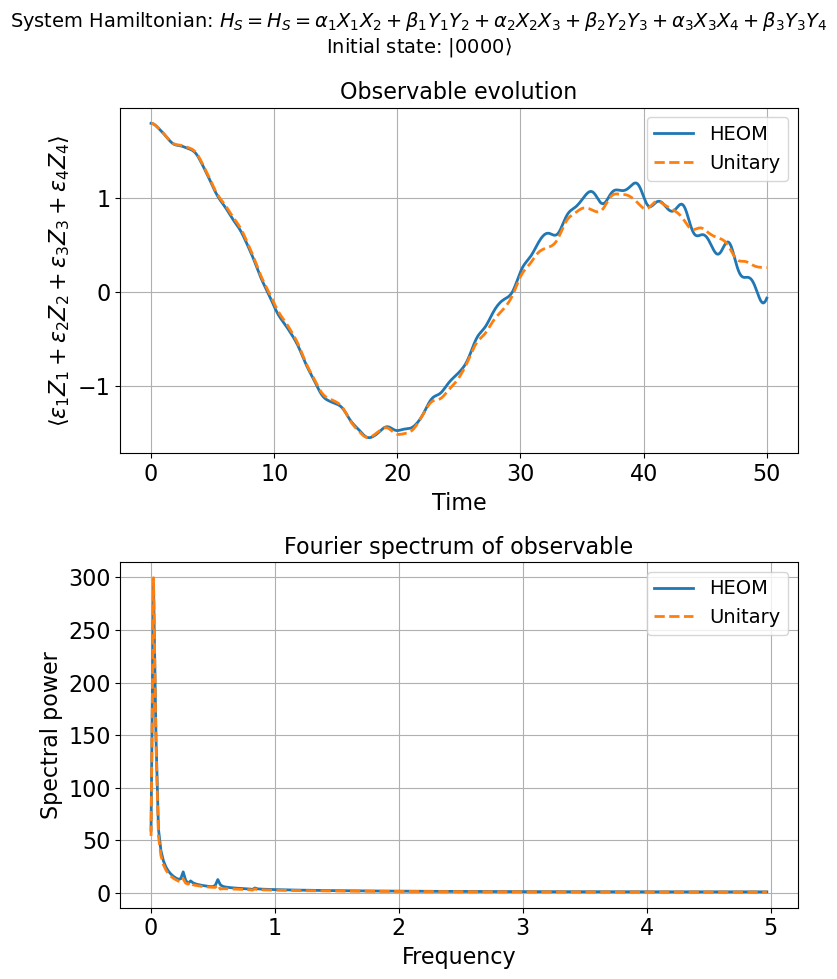

The dominant frequency from the Fourier transform is: 0.0200 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.0200 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [88]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import os
import re
np.random.seed(42)

# System operators (2-qubit Pauli)
X1 = tensor(sigmax(), qeye(2), qeye(2), qeye(2))
X2 = tensor(qeye(2), sigmax(), qeye(2), qeye(2))
X3 = tensor(qeye(2), qeye(2), sigmax(), qeye(2))
X4 = tensor(qeye(2), qeye(2), qeye(2), sigmax())
Y1 = tensor(sigmay(), qeye(2), qeye(2), qeye(2))
Y2 = tensor(qeye(2), sigmay(), qeye(2), qeye(2))
Y3 = tensor(qeye(2), qeye(2), sigmay(), qeye(2))
Y4 = tensor(qeye(2), qeye(2), qeye(2), sigmay())
Z1 = tensor(sigmaz(), qeye(2), qeye(2), qeye(2))
Z2 = tensor(qeye(2), sigmaz(), qeye(2), qeye(2))
Z3 = tensor(qeye(2), qeye(2), sigmaz(), qeye(2))
Z4 = tensor(qeye(2), qeye(2), qeye(2), sigmaz())

# Parameters
epsilon1= 0.1
epsilon2= 0.5
epsilon3= 0.9
epsilon4= 0.3
alpha_list = [0.6, 0.4, 0.6, 0.8, 1.0,1.1,0.7,0.8]
alpha = np.array(alpha_list)

lambda_d = 0.05 * alpha
gamma = 7 * alpha
max_depth=3
Nk=3
T = lambda_d.min()
# System Hamiltonian
H_sys = alpha[0]*Z1 + alpha[1]* Z2 + alpha[2] * Z3

# System Hamiltonian
H_sys = alpha[0]*X1*X2 + alpha[1]* Y1*Y2 + alpha[2] * X2*X3 + alpha[3] * Y2*Y3 + alpha[4] * X3*X4 + alpha[5] * Y3*Y4

# Observable
observable_op = epsilon1 * Z1 + epsilon2 * Z2 + epsilon3 * Z3 + epsilon4 * Z4


# Drude-Lorentz baths for each qubit
baths = [
    DrudeLorentzBath(Z1, lambda_d[0], gamma[0], T, Nk),
    DrudeLorentzBath(Z2, lambda_d[1], gamma[1], T, Nk),
    DrudeLorentzBath(Z3, lambda_d[2], gamma[2], T, Nk),
    DrudeLorentzBath(Z4, lambda_d[3], gamma[3], T, Nk),
]

# HEOM Liouvillian
HL = liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)


zero0 = tensor(basis(2, 0), basis(2, 0),basis(2, 0), basis(2, 0))


psi = (zero0).unit()


# Simulation loop
tlist = np.linspace(0, 50, 500)  

# HEOM evolution
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=Options(nsteps=10000))
rho0 = ket2dm(psi)
result = solver.run(rho0, tlist)
observable_vals = []
for state in result.states:
    rho = state.ptrace([0, 1, 2, 3])  # Full state for all qubits
    val = expect(observable_op, rho)  # Expectation value of the observable
    # Append the expectation value to the list
    observable_vals.append(val)
fft_heom = np.abs(np.fft.fft(observable_vals))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
result_unitary = sesolve(H_sys, psi, tlist)
observable_vals_unitary = []
for state_unitary in result_unitary.states:
        rho_unitary = state_unitary.ptrace([0, 1,2,3])
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_vals_unitary.append(val_unitary)  

# FFT for unitary evolution
pos_mask = freqs >= 0
fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
fft_unitary = fft_unitary[pos_mask]
# Plotting
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(
    r'System Hamiltonian: $H_S =H_S = \alpha_1 X_1 X_2 + \beta_1 Y_1 Y_2 + \alpha_2 X_2 X_3 + \beta_2 Y_2 Y_3 + \alpha_3 X_3 X_4 + \beta_3 Y_3 Y_4  $' + '\n' + r'Initial state: $|0000\rangle$',
    fontsize=14,
    y=y,
    va='top'
)

axs[0].plot(tlist, observable_vals, label="HEOM", lw=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 Z_1 + \epsilon_2 Z_2 + \epsilon_3 Z_3 + \epsilon_4 Z_4  \rangle$')
axs[0].set_title('Observable evolution')
axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)

axs[0].legend( loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs >= 0

freqs= freqs[pos_mask]
fft_heom = fft_heom[pos_mask]
axs[1].plot(freqs, fft_heom, label="HEOM", lw=2)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
axs[1].legend( loc='upper right')
axs[1].grid(True)


name ="ket_00_X1X2_Y1Y2_X2X3_Y2Y3_X3X4_Y3Y4"
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz/4Qubits" #To save the images
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, f"{name}_Drude_Lorentz.png")
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(fft_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary =freqs[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

### $\alpha_1 Z_1 + \alpha_2 Z_2 + \alpha_3 Z_3 + \alpha_4 Z_4$

\begin{equation}
H_S = \alpha_1 Z_1 + \alpha_2 Z_2 + \alpha_3 Z_3 + \alpha_4 Z_4
\end{equation}

10.0%. Run time:   5.88s. Est. time left: 00:00:00:52
20.0%. Run time:  11.14s. Est. time left: 00:00:00:44
30.1%. Run time:  16.33s. Est. time left: 00:00:00:37
40.1%. Run time:  21.41s. Est. time left: 00:00:00:32
50.1%. Run time:  26.39s. Est. time left: 00:00:00:26
60.1%. Run time:  31.69s. Est. time left: 00:00:00:21
70.1%. Run time:  36.78s. Est. time left: 00:00:00:15
80.2%. Run time:  41.84s. Est. time left: 00:00:00:10
90.2%. Run time:  46.82s. Est. time left: 00:00:00:05
100.0%. Run time:  51.71s. Est. time left: 00:00:00:00
Total run time:  51.72s


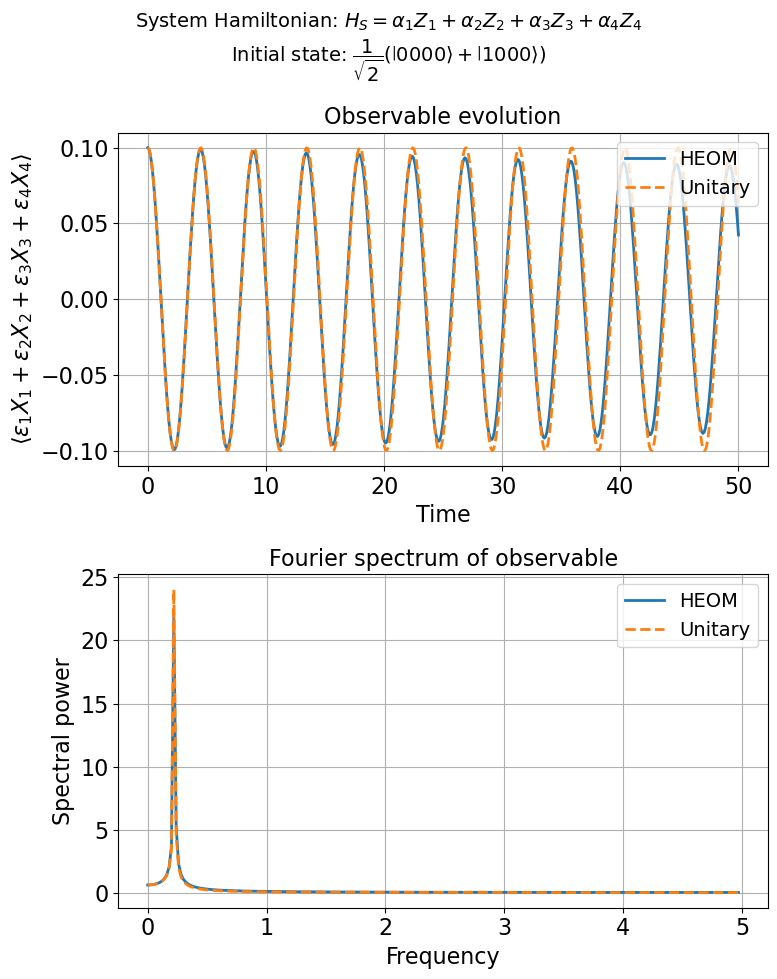

The dominant frequency from the Fourier transform is: 0.2196 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.2196 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [89]:

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import os
import re
np.random.seed(42)

# System operators (2-qubit Pauli)
X1 = tensor(sigmax(), qeye(2), qeye(2), qeye(2))
X2 = tensor(qeye(2), sigmax(), qeye(2), qeye(2))
X3 = tensor(qeye(2), qeye(2), sigmax(), qeye(2))
X4 = tensor(qeye(2), qeye(2), qeye(2), sigmax())
Y1 = tensor(sigmay(), qeye(2), qeye(2), qeye(2))
Y2 = tensor(qeye(2), sigmay(), qeye(2), qeye(2))
Y3 = tensor(qeye(2), qeye(2), sigmay(), qeye(2))
Y4 = tensor(qeye(2), qeye(2), qeye(2), sigmay())
Z1 = tensor(sigmaz(), qeye(2), qeye(2), qeye(2))
Z2 = tensor(qeye(2), sigmaz(), qeye(2), qeye(2))
Z3 = tensor(qeye(2), qeye(2), sigmaz(), qeye(2))
Z4 = tensor(qeye(2), qeye(2), qeye(2), sigmaz())

# Parameters
epsilon1= 0.1
epsilon2= 0.5
epsilon3= 0.9
epsilon4= 0.3
alpha_list = [0.6, 0.4, 0.6, 0.8, 1.0,1.1,0.7,0.8]
alpha = np.array(alpha_list)

lambda_d = 0.05 * alpha
gamma = 7 * alpha
max_depth=3
Nk=3
T = lambda_d.min()
# System Hamiltonian
H_sys = alpha[0]*Z1 + alpha[1]* Z2 + alpha[2] * Z3


# System Hamiltonian
H_sys = alpha1*Z1 + alpha2* Z2 + alpha3 * Z3+ alpha4 *Z4

# Observable
observable_op = epsilon1 * X1 + epsilon2 * X2 + epsilon3 * X3 + epsilon4 * X4


# Drude-Lorentz baths for each qubit
baths = [
    DrudeLorentzBath(X1, lambda_d[0], gamma[0], T, Nk),
    DrudeLorentzBath(X2, lambda_d[1], gamma[1], T, Nk),
    DrudeLorentzBath(X3, lambda_d[2], gamma[2], T, Nk),
    DrudeLorentzBath(X4, lambda_d[3], gamma[3], T, Nk),
]

# HEOM Liouvillian
HL = liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)


zero0 = tensor(basis(2, 0), basis(2, 0),basis(2, 0), basis(2, 0))
one0 = tensor(basis(2, 1), basis(2, 0),basis(2, 0), basis(2, 0))

psi = (zero0+one0).unit()


# Simulation loop
tlist = np.linspace(0, 50, 500)  

# HEOM evolution
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=Options(nsteps=10000))
rho0 = ket2dm(psi)
result = solver.run(rho0, tlist)
observable_vals = []
for state in result.states:
    rho= state.ptrace([0, 1, 2, 3])  # Full state for all qubits
    val = expect(observable_op, rho)  # Expectation value of the observable
    observable_vals.append(val)
fft_heom = np.abs(np.fft.fft(observable_vals))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
result_unitary = sesolve(H_sys, psi, tlist)
observable_vals_unitary = []
for state_unitary in result_unitary.states:
        rho_unitary = state_unitary.ptrace([0, 1,2,3])
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_vals_unitary.append(val_unitary)  

# FFT for unitary evolution
pos_mask = freqs >= 0
fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
fft_unitary = fft_unitary[pos_mask]

# Plotting
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(
    r'System Hamiltonian: $H_S = \alpha_1 Z_1 +\alpha_2 Z_2 + \alpha_3 Z_3+\alpha_4 Z_4 $' + '\n' + r'Initial state: $ \dfrac {1}{\sqrt{2}} (\left |0000\right \rangle+\left |1000\right \rangle) $',
    fontsize=14,
    y=y,
    va='top'
)

axs[0].plot(tlist, observable_vals, label="HEOM", lw=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\langle \epsilon_1 X_1 + \epsilon_2 X_2 + \epsilon_3 X_3 + \epsilon_4 X_4  \rangle$')
axs[0].set_title('Observable evolution')
axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)
axs[0].legend( loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
# Define mask to select only positive frequencies
pos_mask = freqs >= 0

freqs= freqs[pos_mask]
fft_heom = fft_heom[pos_mask]
axs[1].plot(freqs, fft_heom, label="HEOM", lw=2)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
axs[1].legend( loc='upper right')
axs[1].grid(True)


name ="Z1_Z2_Z3_Z4"
save_base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz/4Qubits" #To save the images
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, f"{name}_Drude_Lorentz.png")
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(fft_heom)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(fft_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary =freqs[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

## N QUBIT CODE WITH DRUDE LORENTZ MODEL (Hsb Z)

Initial state trace: 1.0
10.1%. Run time:  92.02s. Est. time left: 00:00:13:38
20.2%. Run time: 175.33s. Est. time left: 00:00:11:32
30.3%. Run time: 267.44s. Est. time left: 00:00:10:15
40.4%. Run time: 373.88s. Est. time left: 00:00:09:11
50.5%. Run time: 488.26s. Est. time left: 00:00:07:58
60.6%. Run time: 609.61s. Est. time left: 00:00:06:36
70.7%. Run time: 731.05s. Est. time left: 00:00:05:02
80.8%. Run time: 854.29s. Est. time left: 00:00:03:22
90.9%. Run time: 975.26s. Est. time left: 00:00:01:37
100.0%. Run time: 1078.78s. Est. time left: 00:00:00:00
Total run time: 1078.84s


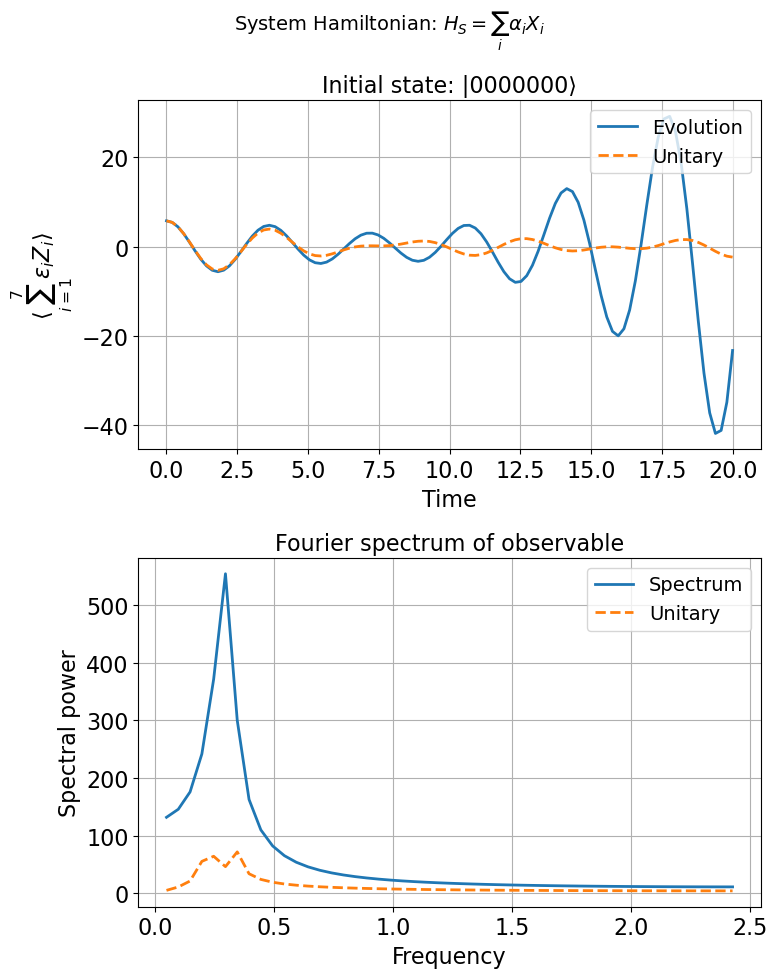

The dominant frequency from the Fourier transform is: 0.2970 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.3465 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 14.29%
Initial state trace: 1.0
10.1%. Run time:  59.85s. Est. time left: 00:00:08:52
20.2%. Run time: 114.49s. Est. time left: 00:00:07:32
30.3%. Run time: 171.93s. Est. time left: 00:00:06:35
40.4%. Run time: 229.85s. Est. time left: 00:00:05:39
50.5%. Run time: 285.51s. Est. time left: 00:00:04:39
60.6%. Run time: 342.97s. Est. time left: 00:00:03:42
70.7%. Run time: 400.81s. Est. time left: 00:00:02:46
80.8%. Run time: 455.90s. Est. time left: 00:00:01:48
90.9%. Run time: 512.15s. Est. time left: 00:00:00:51
100.0%. Run time: 562.01s. Est. time left: 00:00:00:00
Total run time: 562.06s


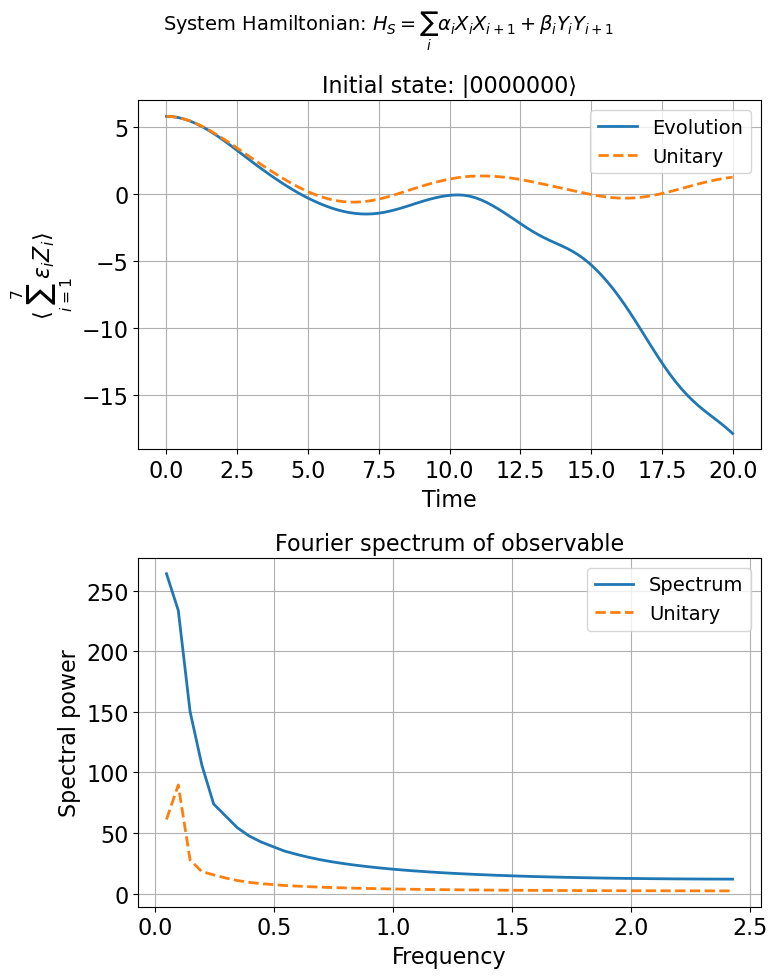

The dominant frequency from the Fourier transform is: 0.0495 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.0990 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 50.00%


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
from qutip import *
import os
import re
np.random.seed(43)

# Parameters - USER CAN CHANGE THESE
num_qubits = 7  # Change this to the desired number of qubits
tlist = np.linspace(0, 20, 100)
save_base_path = rf"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz\{num_qubits}QUBITS"
# Generate random coefficients for the Hamiltonian and observable

epsilon = np.random.uniform(0.7, 1.0, num_qubits)  # Coefficients for observable
alpha_list = np.random.uniform(0.7, 1.1, 2 * num_qubits + 1) 
alpha = np.array(alpha_list)

lambda_d = 0.01 * alpha
gamma = 10 * alpha
max_depth=2
Nk=2
T = lambda_d.min()




def build_op(op_qubit, pos):
    """Build an operator acting on position 'pos' in the full Hilbert space"""
    ops = [qeye(2) for _ in range(num_qubits)]
    ops[pos] = op_qubit
    return tensor(ops)

# Create Pauli operators for all qubits
X_ops = [build_op(sigmax(), i) for i in range(num_qubits)]
Y_ops = [build_op(sigmay(), i) for i in range(num_qubits)]
Z_ops = [build_op(sigmaz(), i) for i in range(num_qubits)]


# Observable operator acting only on the qubits' Hilbert space
observable_op = sum(epsilon[i] * Z_ops[i] for i in range(num_qubits))

# Create list of baths
baths = []
for i in range(num_qubits):
    baths.append(DrudeLorentzBath(Z_ops[i], lambda_d[i], gamma[i], T, Nk))

# System Hamiltonian: Nearest-neighbor XX and YY interactions
Hs_1 = 0
for i in range(num_qubits):
    Hs_1 += alpha[i]* X_ops[i]
Hs_2 = 0
for i in range(num_qubits-1):
    Hs_2+= alpha[i] * X_ops[i] * X_ops[i+1]  # XX coupling
    Hs_2 += alpha[2*i+1] * Y_ops[i] * Y_ops[i+1]  # YY coupling


# Initial state: all qubits in |0⟩ and all bath modes in vacuum
zero_state = tensor([basis(2, 0) for _ in range(num_qubits)])
psi = zero_state.unit()


for i in range(2):
    if i == 0:
        Hs = Hs_1
    else:
        if num_qubits == 1:
            print("For 1 qubit, only the first Hamiltonian is applicable.")
            continue
        else:
            Hs = Hs_2

    # HEOM evolution
    solver = HEOMSolver(Hs, baths, max_depth=max_depth, options=Options(nsteps=10000))
    rho0 = ket2dm(psi)
    print(f"Initial state trace: {rho0.tr()}")  # Should be 1.
    result = solver.run(rho0, tlist)
    observable_vals = []


    for state in  result.states:
        rho = state.ptrace(list(range(num_qubits)))  # Full state for all qubits
        rho = rho / rho.tr()  # Normalize the state
        val = expect(observable_op, rho)  # Expectation value of the observable
        # Append the expectation value to the list
        observable_vals.append(val)

    # Fourier Transform
    energy_fft = np.abs(np.fft.fft(observable_vals))
    freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

    # Select only positive frequencies
    pos_mask = freqs > 0
    freqs = freqs[pos_mask]
    energy_fft = energy_fft[pos_mask]
    result_unitary = sesolve(Hs, psi, tlist)
    observable_vals_unitary = []
    for state_unitary in result_unitary.states:
            rho_unitary = state_unitary.ptrace(list(range(num_qubits)))
            rho_unitary = rho_unitary / rho_unitary.tr()
            val_unitary = expect(observable_op, rho_unitary)
            observable_vals_unitary.append(val_unitary)

    # FFT for unitary evolution
    fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
    freqs_unitary = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
    pos_mask_unitary = freqs_unitary > 0

    # Aplica el filtro correcto
    fft_unitary = fft_unitary[pos_mask_unitary]
    freqs_unitary = freqs_unitary[pos_mask_unitary]

    # Plotting
    if layout == 'vertical': #Layout was defined at the beginning of the jupyter notebook
        fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    else:
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))


    # Create Hamiltonian title string
    if i == 0:
        ham_title = r'System Hamiltonian: $H_S = \sum_{i}^{%d \alpha_i X_i$' % num_qubits
        title = ham_title.replace(r'\alpha', 'alpha').replace(r'\ ', '_').replace(' ', '_').replace('$', '').replace('{', '').replace('}', '')
    else:
        # For the second Hamiltonian with nearest-neighbor interactions
        ham_title = r'System Hamiltonian: $H_S = \sum_{i}^{%d \alpha_{i} X_i X_{i+1} + \beta_{i} Y_i Y_{i+1}$' % num_qubits
        title = ham_title.replace(r'\alpha', 'alpha').replace(r'\ ', '_').replace(' ', '_').replace('$', '').replace('{', '').replace('}', '')
    obs_label=r'$\langle \sum_{i=1}^{%d} \epsilon_i Z_i \rangle$' % num_qubits

    # Left: Observable
    fig.suptitle(ham_title, fontsize=14, y=y)
    axs[0].plot(tlist, observable_vals, label='Evolution', lw=2)
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel(obs_label)
    axs[0].set_title(f'Initial state: |{"0"*num_qubits}⟩')
    axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)
    axs[0].legend( loc='upper right')
    axs[0].grid(True)

    # Right: Fourier spectrum
    axs[1].plot(freqs, energy_fft, label='Spectrum', lw=2)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Spectral power')
    axs[1].set_title('Fourier spectrum of observable')
    axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
    axs[1].legend( loc='upper right')
    axs[1].grid(True)

    # Save and show
    name = f"{num_qubits}_{i}_general_code_1.png"
    os.makedirs(save_base_path, exist_ok=True)
    filename = os.path.join(save_base_path,"general")
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()



    # Find the dominant frequency in the noisy spectrum
    idx_peak = np.argmax(energy_fft)

    # Use the frequency corresponding to the peak in the noisy spectrum
    freq_peak = freqs[idx_peak]
    # Find the dominant frequency in the unitary spectrum
    idx_peak_unitary =  np.argmax(fft_unitary)

    # Use the frequency corresponding to the unitary in the noisy spectrum
    freq_peak_unitary =freqs[idx_peak_unitary]
    print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
    print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
    relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
    print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

## N QUBIT CODE WITH DRUDE LORENTZ MODEL (Hsb Z)

Initial state trace: 0.9999999999999998
10.1%. Run time:  11.59s. Est. time left: 00:00:01:43
20.2%. Run time:  19.56s. Est. time left: 00:00:01:17
30.3%. Run time:  27.40s. Est. time left: 00:00:01:03
40.4%. Run time:  35.30s. Est. time left: 00:00:00:52
50.5%. Run time:  42.98s. Est. time left: 00:00:00:42
60.6%. Run time:  50.78s. Est. time left: 00:00:00:33
70.7%. Run time:  58.52s. Est. time left: 00:00:00:24
80.8%. Run time:  66.32s. Est. time left: 00:00:00:15
90.9%. Run time:  74.13s. Est. time left: 00:00:00:07
100.0%. Run time:  82.47s. Est. time left: 00:00:00:00
Total run time:  82.49s


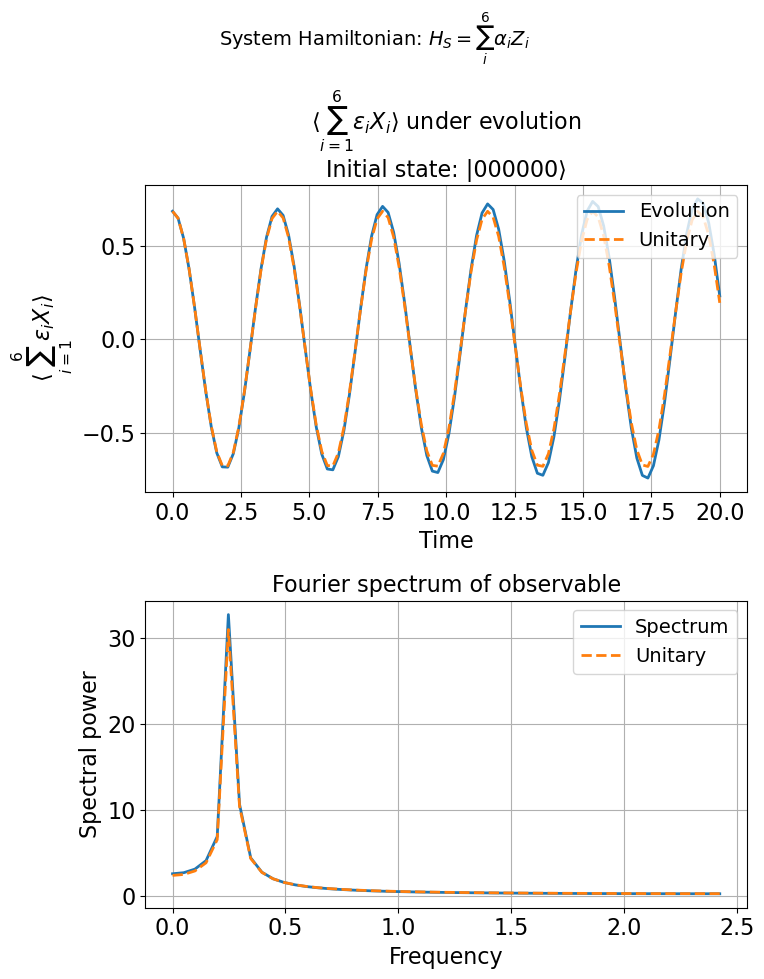

The dominant frequency from the Fourier transform is: 0.2475 (units of 1/time)
The dominant frequency from the Fourier transform (unitary) is: 0.2475 (units of 1/time)
The relative error between the noisy and unitary dominant frequencies is: 0.00%


In [10]:


import numpy as np
import matplotlib.pyplot as plt
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
from qutip import *
import os
import re
np.random.seed(42)

# Parameters - USER CAN CHANGE THESE
num_qubits = 6  # Change this to the desired number of qubits

tlist = np.linspace(0, 20, 100)
save_base_path = rf"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz\{num_qubits}QUBITS"
# Generate random coefficients for the Hamiltonian and observable
epsilon = np.random.uniform(0.5, 1.0, num_qubits)  # Coefficients for observable
alpha_list = np.random.uniform(0.8, 1.1, 2 * num_qubits + 1) 
alpha = np.array(alpha_list)

lambda_d = 0.02 * alpha
gamma = 8 * alpha
max_depth=2
Nk=2
T = lambda_d.min()


def build_op(op_qubit, pos):
    """Build an operator acting on position 'pos' in the full Hilbert space"""
    ops = [qeye(2) for _ in range(num_qubits)]
    ops[pos] = op_qubit
    return tensor(ops)

# Create Pauli operators for all qubits
X_ops = [build_op(sigmax(), i) for i in range(num_qubits)]
Y_ops = [build_op(sigmay(), i) for i in range(num_qubits)]
Z_ops = [build_op(sigmaz(), i) for i in range(num_qubits)]


# Observable operator acting only on the qubits' Hilbert space
observable_op = sum(epsilon[i] * X_ops[i] for i in range(num_qubits))

# Create list of baths
baths = []
for i in range(num_qubits):
    baths.append(DrudeLorentzBath(X_ops[i], lambda_d[i], gamma[i], T, Nk))

# System Hamiltonian: Nearest-neighbor XX and YY interactions
Hs_1 = 0
for i in range(num_qubits):
    Hs_1 += alpha[i]* Z_ops[i]



# Initial state: all qubits in |0⟩ and all bath modes in vacuum
zero_state = tensor([basis(2, 0) for _ in range(num_qubits)])
one_state = tensor([basis(2, 1)]+[basis(2, 0) for _ in range(1,num_qubits)])
psi = zero_state+one_state
psi = psi.unit()


Hs = Hs_1

# HEOM evolution
solver = HEOMSolver(Hs, baths, max_depth=max_depth, options=Options(nsteps=10000))
rho0 = ket2dm(psi)
print(f"Initial state trace: {rho0.tr()}")  # Should be 1.
result = solver.run(rho0, tlist)
observable_vals = []


for state in  result.states:
    val = 0
    rho = state.ptrace(list(range(num_qubits)))  # Full state for all qubits
    rho = rho / rho.tr()  # Normalize
    val = expect(observable_op, rho)  # Expectation value of the observable
    observable_vals.append(val)

# Fourier Transform
energy_fft = np.abs(np.fft.fft(observable_vals))
freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

# Select only positive frequencies
pos_mask = freqs >= 0
freqs = freqs[pos_mask]
energy_fft = energy_fft[pos_mask]
result_unitary = sesolve(Hs, psi, tlist)
observable_vals_unitary = []
for state_unitary in result_unitary.states:
        rho_unitary = state_unitary.ptrace(list(range(num_qubits)))
        rho_unitary = rho_unitary / rho_unitary.tr()
        val_unitary = expect(observable_op, rho_unitary)
        observable_vals_unitary.append(val_unitary)

fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
freqs_unitary = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
pos_mask_unitary = freqs_unitary >= 0

# Aplica el filtro correcto
fft_unitary = fft_unitary[pos_mask_unitary]
freqs_unitary = freqs_unitary[pos_mask_unitary]

# Plotting
if layout == 'vertical':
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))


# Create Hamiltonian title string

ham_title = r'System Hamiltonian: $H_S = \sum_{i}^{%d} \alpha_i Z_i$'% num_qubits

title = ham_title.replace(r'\alpha', 'alpha').replace(r'\ ', '_').replace(' ', '_').replace('$', '').replace('{', '').replace('}', '')

# Left: Observable
fig.suptitle(ham_title, fontsize=14, y=y)
if num_qubits == 1:
    obs_label = r'$\langle ' + fr'\epsilon_1 X_1 \rangle$'
else:
    obs_label=r'$\langle \sum_{i=1}^{%d} \epsilon_i X_i \rangle$' % num_qubits
axs[0].plot(tlist, observable_vals, label='Evolution', lw=2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel(obs_label)
axs[0].set_title(f'{obs_label} under evolution\nInitial state: |{"0"*num_qubits}⟩')
axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)
axs[0].legend(  loc='upper right')
axs[0].grid(True)

# Right: Fourier spectrum
axs[1].plot(freqs, energy_fft, label='Spectrum', lw=2)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Spectral power')
axs[1].set_title('Fourier spectrum of observable')
axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
axs[1].legend( loc='upper right')
axs[1].grid(True)

# Save and show
name = f"{num_qubits}_{2}_general_code.png"
os.makedirs(save_base_path, exist_ok=True)
filename = os.path.join(save_base_path, name)
plt.tight_layout()
plt.savefig(filename, bbox_inches='tight')
plt.show()



# Find the dominant frequency in the noisy spectrum
idx_peak = np.argmax(energy_fft)

# Use the frequency corresponding to the peak in the noisy spectrum
freq_peak = freqs[idx_peak]
# Find the dominant frequency in the unitary spectrum
idx_peak_unitary = np.argmax(fft_unitary)

# Use the frequency corresponding to the unitary in the noisy spectrum
freq_peak_unitary =freqs[idx_peak_unitary]
print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

## N Qubit code with an observable of multiple qubits

# Ohmic Bath

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import qutip as qt
from qutip import *
import os
import re
np.random.seed(43)

# Parameters - USER CAN CHANGE THESE
num_qubits = 1  # Change this to the desired number of qubits
tlist = np.linspace(0, 20, 100)
save_base_path = rf"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\systembath\Drude_Lorentz\{num_qubits}QUBITS"
# Generate random coefficients for the Hamiltonian and observable

epsilon = np.random.uniform(0.7, 1.0, num_qubits)  # Coefficients for observable
alpha_list = np.random.uniform(0.7, 1.1, 2 * num_qubits + 1) 
alpha = np.array(alpha_list)

lambda_d = 0.01 * alpha
gamma = 10 * alpha
max_depth=2
Nk=2
T = lambda_d.min()




def build_op(op_qubit, pos):
    """Build an operator acting on position 'pos' in the full Hilbert space"""
    ops = [qeye(2) for _ in range(num_qubits)]
    ops[pos] = op_qubit
    return tensor(ops)

# Create Pauli operators for all qubits
X_ops = [build_op(sigmax(), i) for i in range(num_qubits)]
Y_ops = [build_op(sigmay(), i) for i in range(num_qubits)]
Z_ops = [build_op(sigmaz(), i) for i in range(num_qubits)]


# Observable operator acting only on the qubits' Hilbert space
observable_op = sum(gamma[i] * Z_ops[i] * Z_ops[i+1] for i in range(num_qubits - 1))

# Create list of baths
baths = []
for i in range(num_qubits):
    env = OhmicEnvironment(T=T, alpha=lambda_d[i], wc=gamma[i], s=1)  # s=1 → entorno óhmico
    approx_env, _ = env.approximate("cf", tlist, Nr_max=Nk, Ni_max=Nk)
    baths.append(approx_env)

# System Hamiltonian: Nearest-neighbor XX and YY interactions
Hs_1 = 0
for i in range(num_qubits):
    Hs_1 += alpha[i]* X_ops[i]
Hs_2 = 0
for i in range(num_qubits-1):
    Hs_2+= alpha[i] * X_ops[i] * X_ops[i+1]  # XX coupling
    Hs_2 += alpha[2*i+1] * Y_ops[i] * Y_ops[i+1]  # YY coupling


# Initial state: all qubits in |0⟩ and all bath modes in vacuum
zero_state = tensor([basis(2, 0) for _ in range(num_qubits)])
psi = zero_state.unit()


for i in range(2):
    if i == 0:
        Hs = Hs_1
    else:
        if num_qubits == 1:
            print("For 1 qubit, only the first Hamiltonian is applicable.")
            continue
        else:
            Hs = Hs_2

    # HEOM evolution
    solver = HEOMSolver(Hs, baths, max_depth=max_depth, options=Options(nsteps=10000))
    rho0 = ket2dm(psi)
    print(f"Initial state trace: {rho0.tr()}")  # Should be 1.
    result = solver.run(rho0, tlist)
    observable_vals = []


    for state in  result.states:
        rho = state.ptrace(list(range(num_qubits)))  # Full state for all qubits
        rho = rho / rho.tr()  # Normalize the state
        val = expect(observable_op, rho)  # Expectation value of the observable
        # Append the expectation value to the list
        observable_vals.append(val)

    # Fourier Transform
    energy_fft = np.abs(np.fft.fft(observable_vals))
    freqs = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])

    # Select only positive frequencies
    pos_mask = freqs >= 0
    freqs = freqs[pos_mask]
    energy_fft = energy_fft[pos_mask]
    result_unitary = sesolve(Hs, psi, tlist)
    observable_vals_unitary = []
    for state_unitary in result_unitary.states:
            rho_unitary = state_unitary.ptrace(list(range(num_qubits)))
            rho_unitary = rho_unitary / rho_unitary.tr()
            val_unitary = expect(observable_op, rho_unitary)
            observable_vals_unitary.append(val_unitary)

    # FFT for unitary evolution
    fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
    freqs_unitary = np.fft.fftfreq(len(tlist), d=tlist[1] - tlist[0])
    pos_mask_unitary = freqs_unitary >= 0

    # Aplica el filtro correcto
    fft_unitary = fft_unitary[pos_mask_unitary]
    freqs_unitary = freqs_unitary[pos_mask_unitary]

    # Plotting
    if layout == 'vertical': #Layout was defined at the beginning of the jupyter notebook
        fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    else:
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))


    # Create Hamiltonian title string
    if i == 0:
        ham_title = r'System Hamiltonian: $H_S = \sum_{i} \alpha_i X_i$'
        title = ham_title.replace(r'\alpha', 'alpha').replace(r'\ ', '_').replace(' ', '_').replace('$', '').replace('{', '').replace('}', '')
    else:
        # For the second Hamiltonian with nearest-neighbor interactions
        ham_title = r'System Hamiltonian: $H_S = \sum_{i} \alpha_{i} X_i X_{i+1} + \beta_{i} Y_i Y_{i+1}$'
        title = ham_title.replace(r'\alpha', 'alpha').replace(r'\ ', '_').replace(' ', '_').replace('$', '').replace('{', '').replace('}', '')
    obs_label=r'$\langle \sum_{i=1}^{%d} \epsilon_i Z_i \rangle$' % num_qubits

    # Left: Observable
    fig.suptitle(ham_title, fontsize=14, y=y)
    axs[0].plot(tlist, observable_vals, label='Evolution', lw=2)
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel(obs_label)
    axs[0].set_title(f'Initial state: |{"0"*num_qubits}⟩')
    axs[0].plot(tlist, observable_vals_unitary, label="Unitary", linestyle="--", lw=2)
    axs[0].legend( loc='upper right')
    axs[0].grid(True)

    # Right: Fourier spectrum
    axs[1].plot(freqs, energy_fft, label='Spectrum', lw=2)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Spectral power')
    axs[1].set_title('Fourier spectrum of observable')
    axs[1].plot(freqs, fft_unitary, label="Unitary", linestyle="--", lw=2)
    axs[1].legend( loc='upper right')
    axs[1].grid(True)

    # Save and show
    name = f"{num_qubits}_{i}_general_code_1.png"
    os.makedirs(save_base_path, exist_ok=True)
    filename = os.path.join(save_base_path,"general")
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()



    # Find the dominant frequency in the noisy spectrum
    idx_peak = np.argmax(energy_fft)

    # Use the frequency corresponding to the peak in the noisy spectrum
    freq_peak = freqs[idx_peak]
    # Find the dominant frequency in the unitary spectrum
    idx_peak_unitary =  np.argmax(fft_unitary)

    # Use the frequency corresponding to the unitary in the noisy spectrum
    freq_peak_unitary =freqs[idx_peak_unitary]
    print(f"The dominant frequency from the Fourier transform is: {freq_peak:.4f} (units of 1/time)")
    print(f"The dominant frequency from the Fourier transform (unitary) is: {freq_peak_unitary:.4f} (units of 1/time)")
    relative_error = abs(freq_peak - freq_peak_unitary) / freq_peak_unitary * 100
    print(f"The relative error between the noisy and unitary dominant frequencies is: {relative_error:.2f}%")

ImportError: cannot import name 'OhmicEnvironment' from 'qutip.solver.heom' (c:\Users\jalej\anaconda3\Lib\site-packages\qutip\solver\heom\__init__.py)